In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision, MeanIoU

from tensorflow.keras import backend as K
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

IMAGE_SIZE = 128
EPOCHS = 65
BATCH = 8

PATH = "/kaggle/input/chaostrvalte/CHAOS_tr_va_te"




def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_image(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


train_x_folder_path = "/kaggle/input/chaostrvalte/CHAOS_tr_val_te/train/HU_CT_Images"
train_x_file_names = os.listdir(train_x_folder_path)
train_x = [os.path.join(train_x_folder_path, file_name) for file_name in train_x_file_names]
# train_x

train_y_folder_path = "/kaggle/input/chaostrvalte/CHAOS_tr_val_te/train/Liver_Masks"
train_y_file_names = os.listdir(train_y_folder_path)
train_y = [os.path.join(train_y_folder_path, file_name) for file_name in train_y_file_names]
# train_y




valid_x_folder_path = "/kaggle/input/chaostrvalte/CHAOS_tr_val_te/val/HU_CT_Images"
valid_x_file_names = os.listdir(valid_x_folder_path)
valid_x = [os.path.join(valid_x_folder_path, file_name) for file_name in valid_x_file_names]
# valid_x

valid_y_folder_path = "/kaggle/input/chaostrvalte/CHAOS_tr_val_te/val/Liver_Masks"
valid_y_file_names = os.listdir(valid_y_folder_path)
valid_y = [os.path.join(valid_y_folder_path, file_name) for file_name in valid_y_file_names]
# valid_y


test_x_folder_path = "/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/HU_CT_Images"
test_x_file_names = os.listdir(test_x_folder_path)
test_x = [os.path.join(test_x_folder_path, file_name) for file_name in test_x_file_names]
# test_x

test_y_folder_path = "/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/Liver_Masks"
test_y_file_names = os.listdir(test_y_folder_path)
test_y = [os.path.join(test_y_folder_path, file_name) for file_name in test_y_file_names]
# test_y


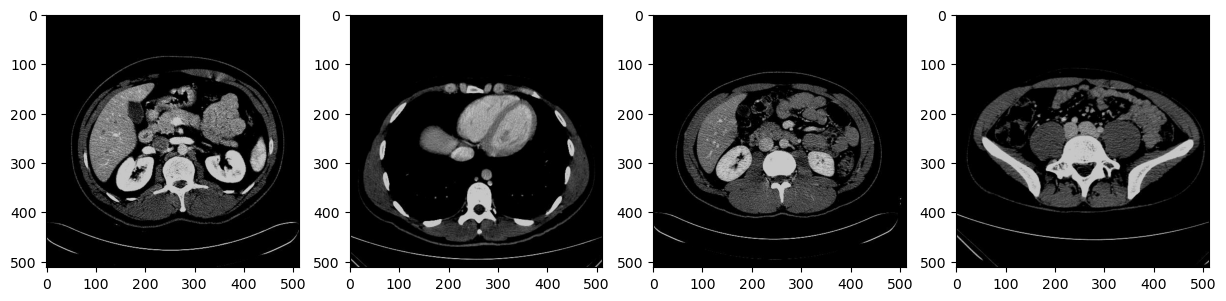

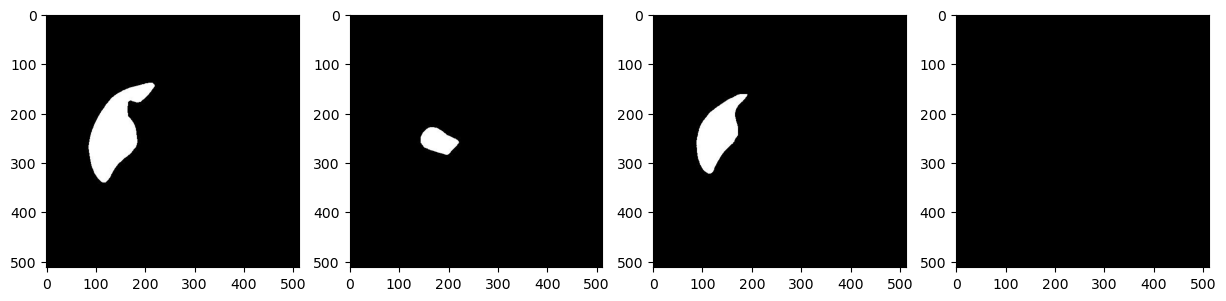

In [ ]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x


fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [ ]:
from tensorflow import keras
!pip install keras-unet-collection



from keras_unet_collection import models, utils

# the indicator of a fresh run
first_time_running = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))


def voe_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    voe = 1.0 - (intersection / union)
    return voe

def rvd_metric(y_true, y_pred):
    volume_pred = tf.reduce_sum(y_pred)
    volume_gt = tf.reduce_sum(y_true)
    rvd = ((volume_pred - volume_gt) / volume_gt)
    return rvd

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    iou_score = intersection / (union + smooth)
    return iou_score

LR = 1e-4
opt = tf.keras.optimizers.legacy.Nadam(LR)
metrics = [dice_coef, recall, precision, f1_score, accuracy, iou, voe_metric, rvd_metric]


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [ ]:
from keras.models import load_model
model = load_model('/kaggle/input/3dircadbmodels/UNet3plus2D.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 unet3plus_down0_0 (Conv2D)     (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 unet3plus_down0_0_bn (BatchNor  (None, 128, 128, 64  256        ['unet3plus_down0_0[0][0]']      
 malization)                    )                                                             

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

print("For UNet3+:")
model.evaluate(test_dataset, steps=test_steps)

For UNet3+:
72/72 [==============================] - 20s 112ms/step - loss: 0.0672 - dice_coef: 0.9328 - recall: 0.9057 - precision: 0.9646 - f1_score: 0.9332 - accuracy: 0.9792 - iou: 0.8757 - voe_metric: 0.1243 - rvd_metric: -0.0588


[0.06724583357572556,
 0.9327540993690491,
 0.9056766033172607,
 0.9645504355430603,
 0.9331527352333069,
 0.9792042970657349,
 0.8756731748580933,
 0.12432685494422913,
 -0.05884401500225067]

/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/HU_CT_Images/54.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/Liver_Masks/54.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/HU_CT_Images/672.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/Liver_Masks/672.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/HU_CT_Images/759.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/Liver_Masks/759.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/HU_CT_Images/0.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/Liver_Masks/0.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/HU_CT_Images/916.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/Liver_Masks/916.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/HU_CT_Images/2035.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/Liver_Masks/2035.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/HU_CT_Images/1183.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/Liver_Masks/1183.jpg
/kaggle/input/chaostrvalte/CHAOS_tr_val_te/

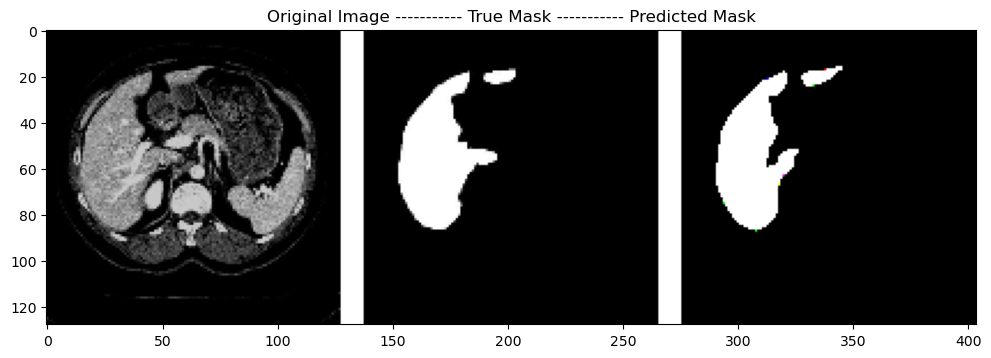

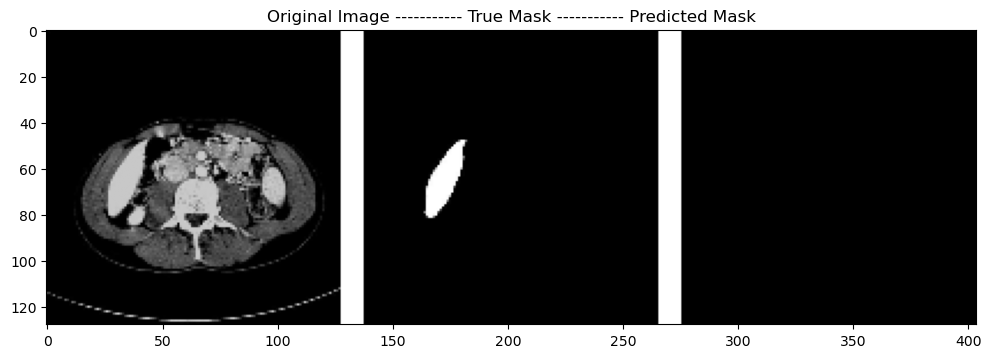

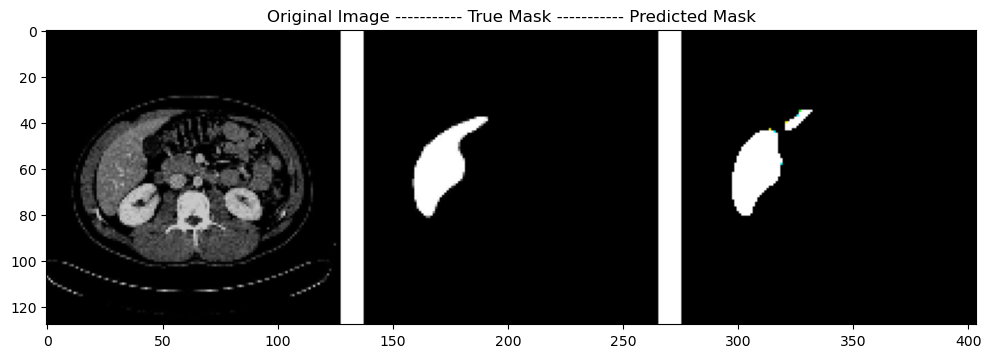

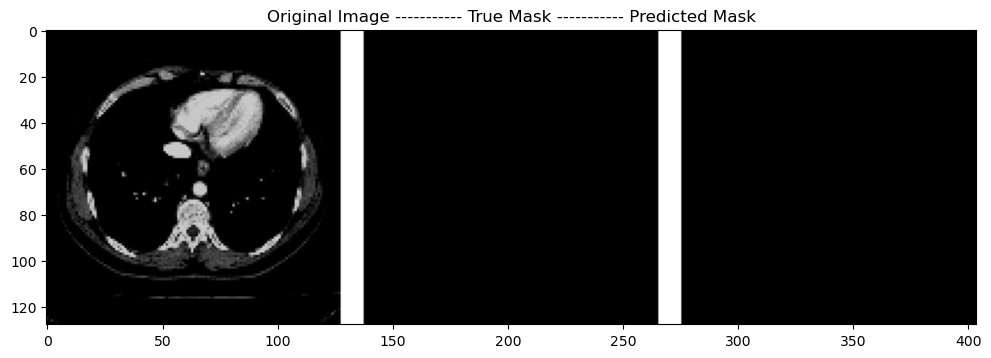

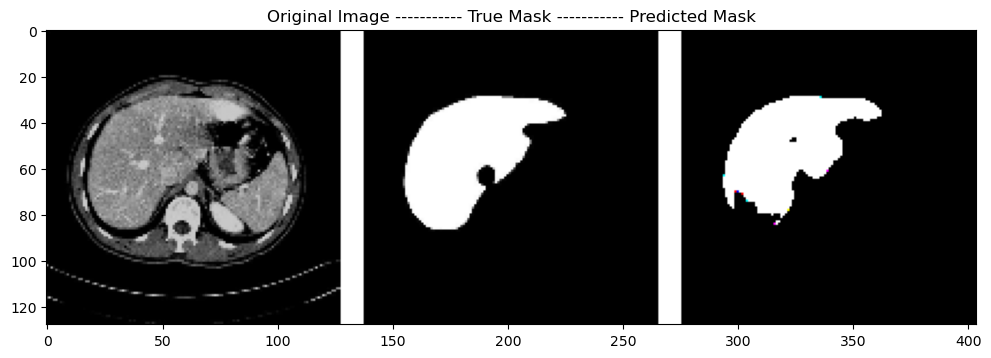

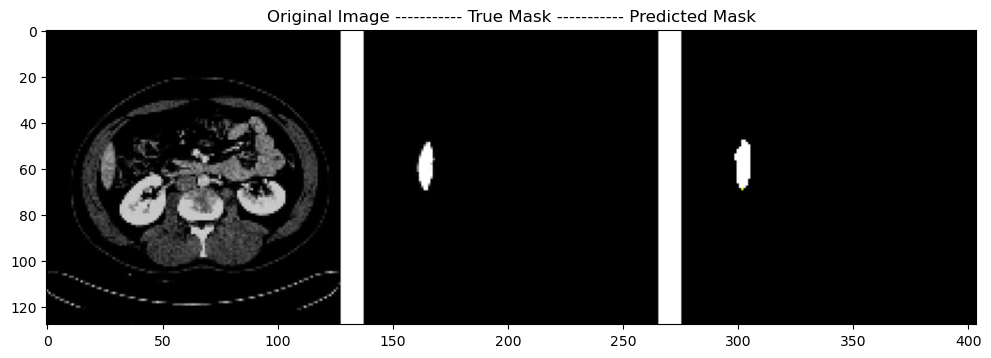

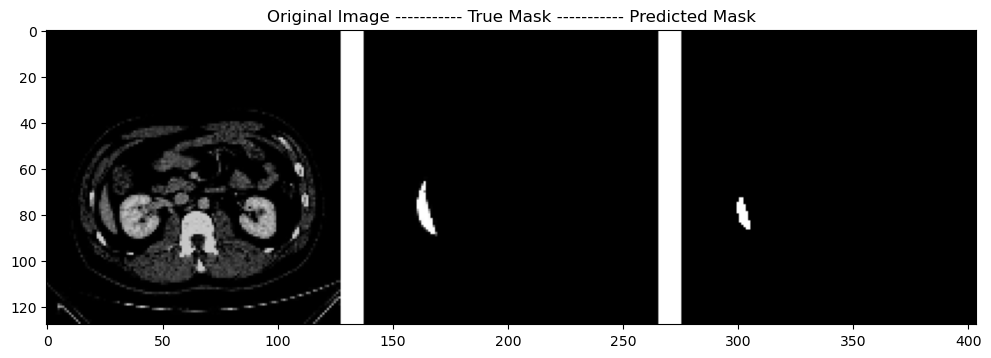

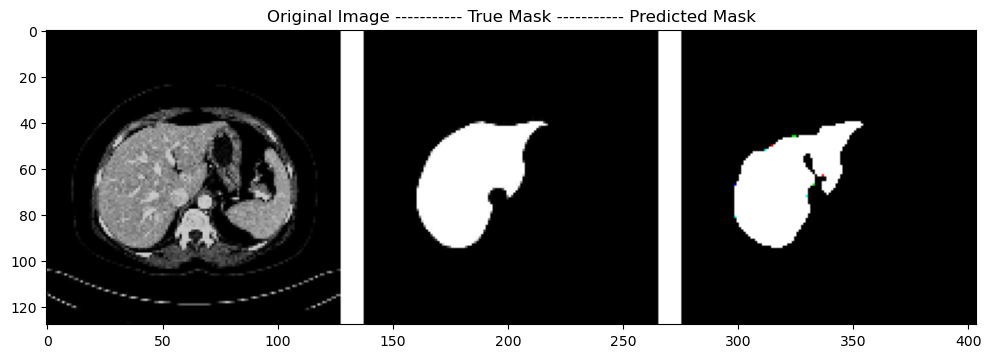

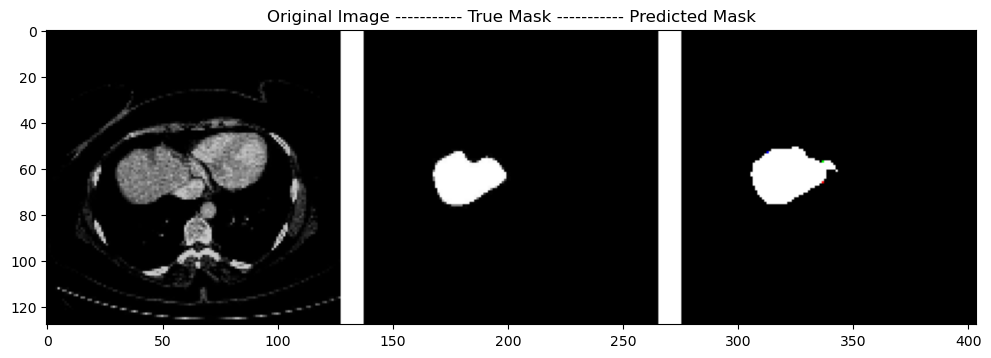

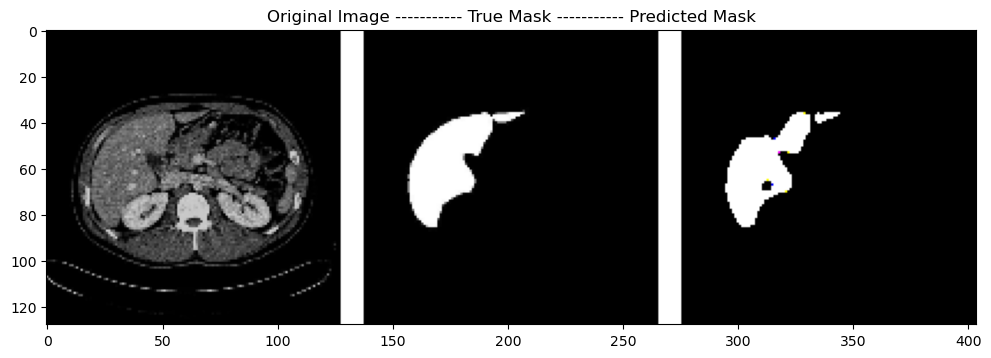

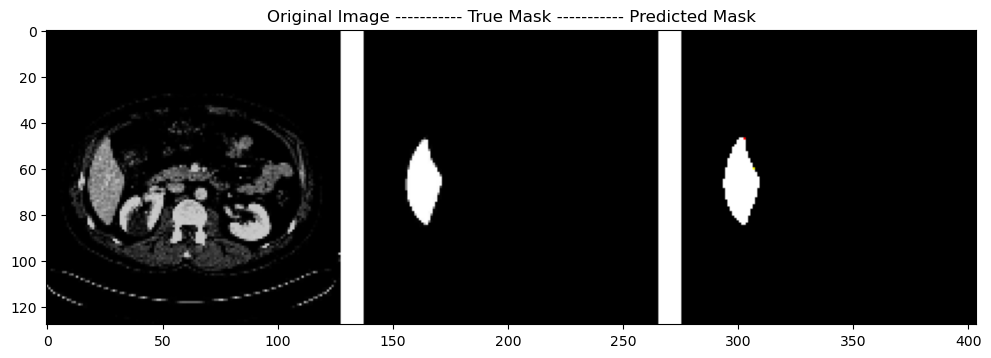

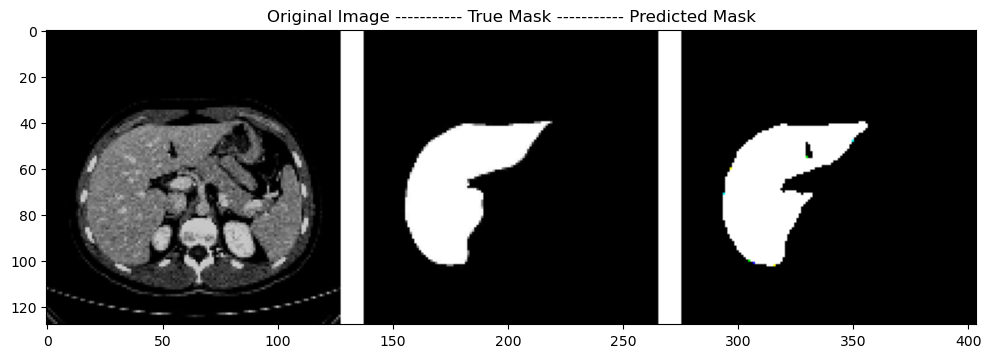

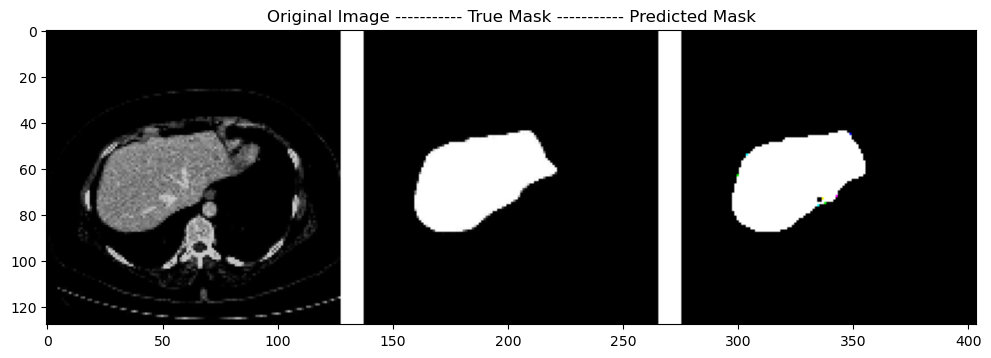

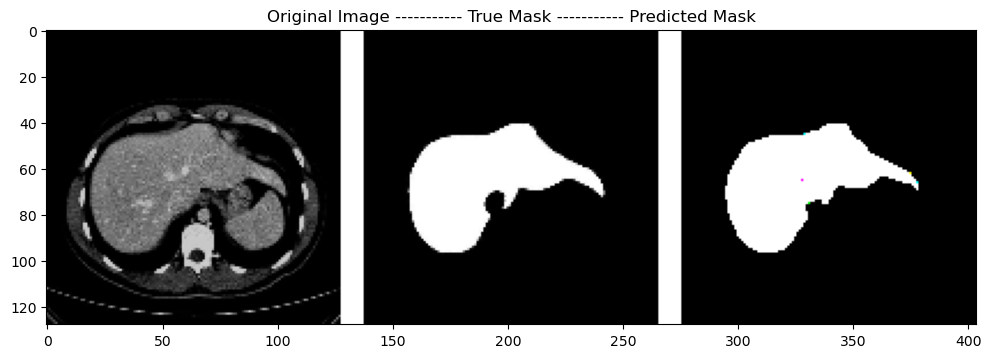

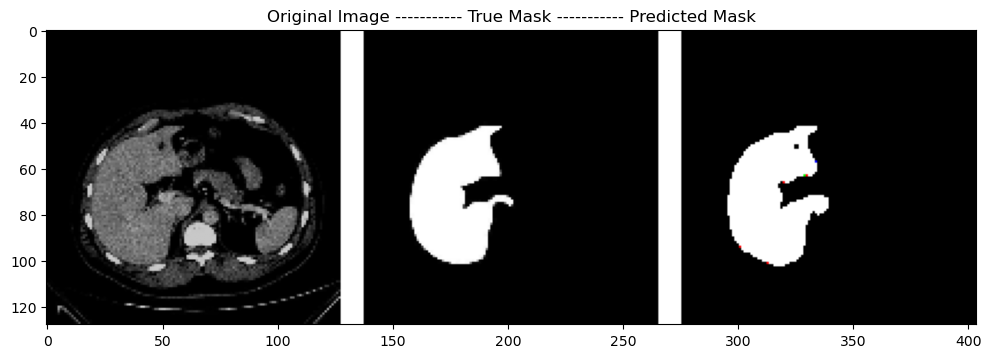

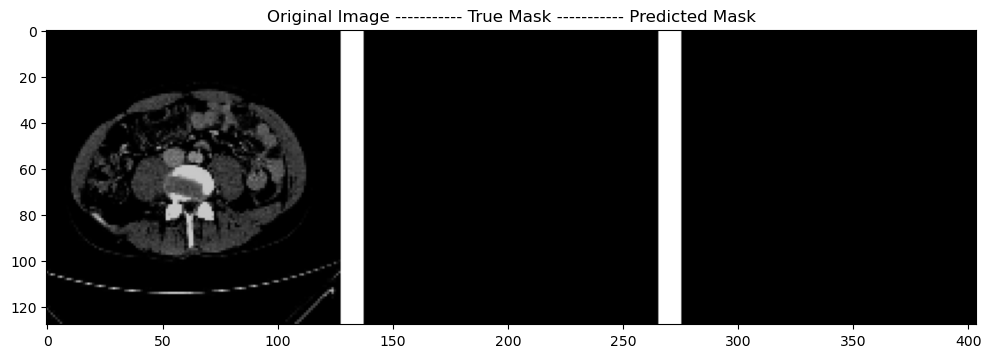

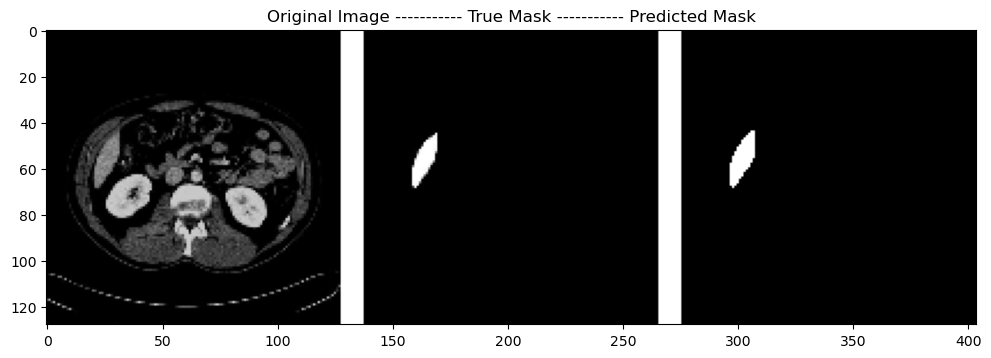

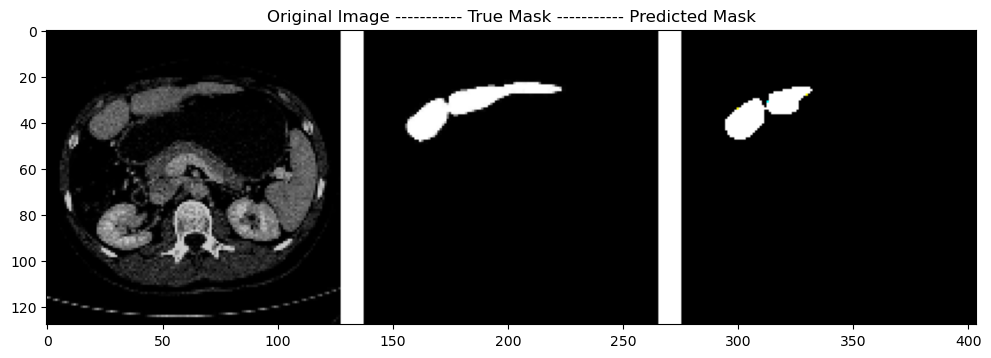

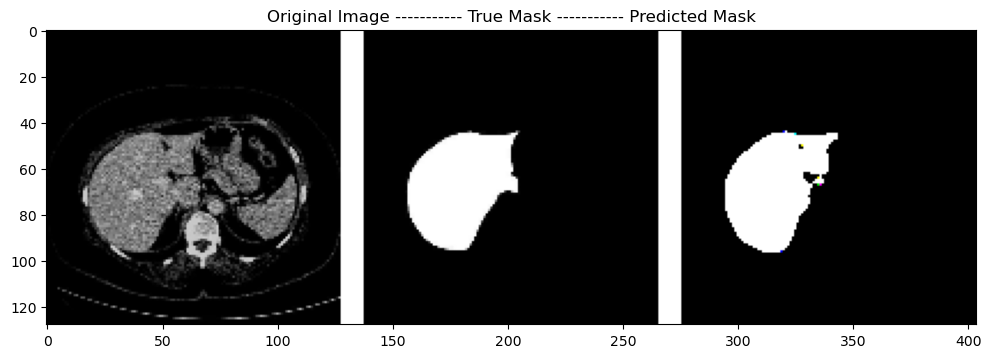

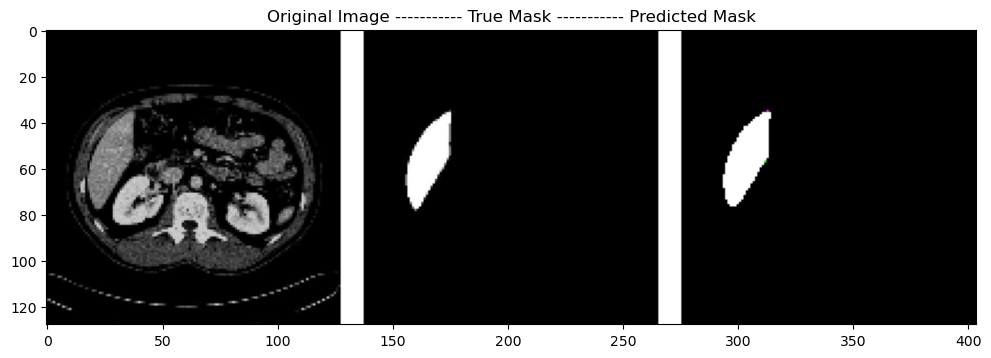

In [ ]:

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (128, 128))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (128, 128))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

for i, (x, y) in enumerate(zip(test_x[80:100], test_y[80:100])):
    print(x)
    print(y)
    x = read_image(x)
    y = read_mask(y)
    y_pred1 = model.predict(np.expand_dims(x, axis=0), verbose=0)[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3)) * 255
    all_images = [
        x,
        white_line,
        mask_parse(y),
        white_line,
        y_pred1
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    plt.title("Original Image ----------- True Mask ----------- Predicted Mask")
    imgplot = plt.imshow(image)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv11_1 (Conv2D)              (None, 128, 128, 32  896         ['main_input[0][0]']             
                                )                                                                 
                                                                                                  
 dp11_1 (Dropout)               (None, 128, 128, 32  0           ['conv11_1[0][0]']               
                                )                                                           

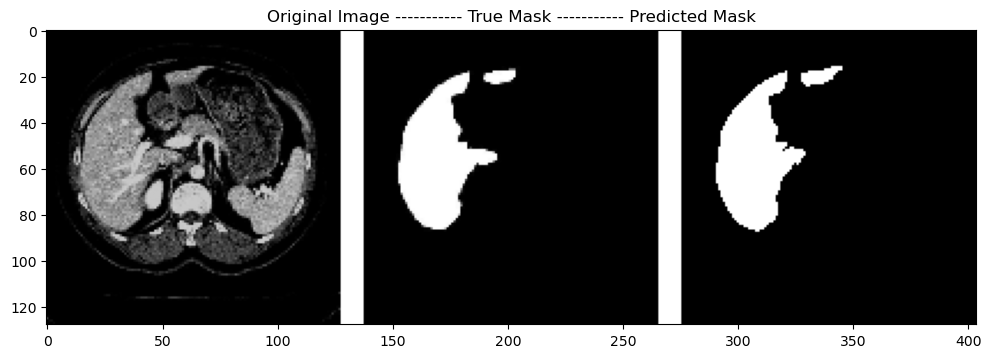

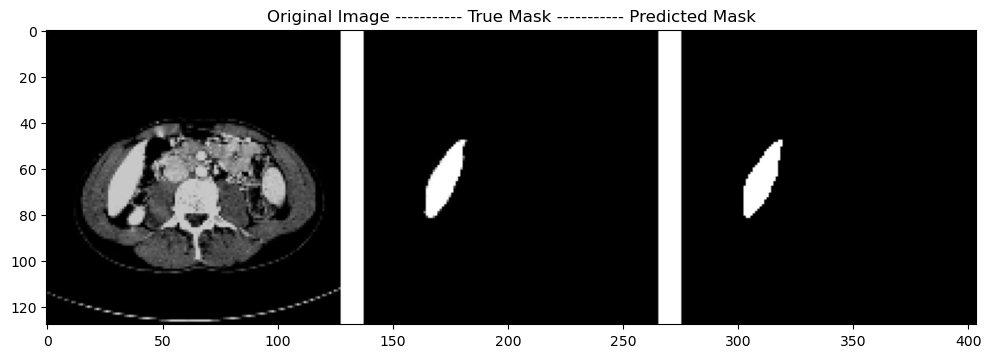

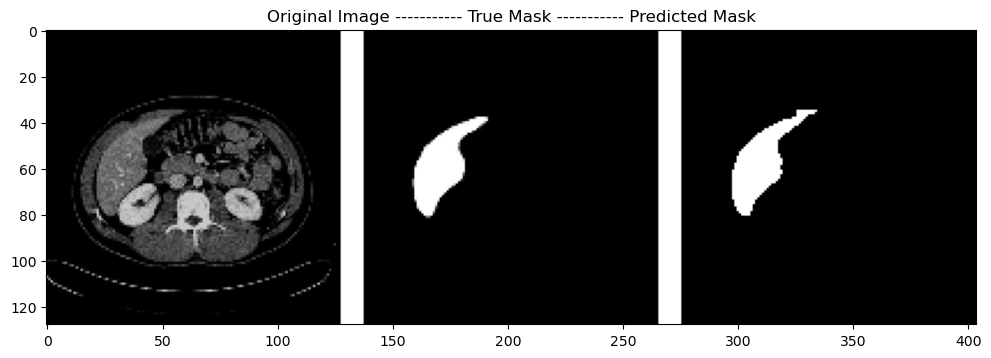

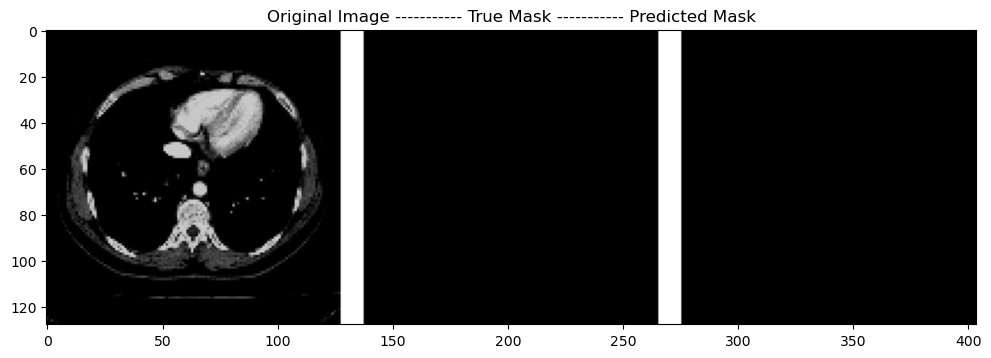

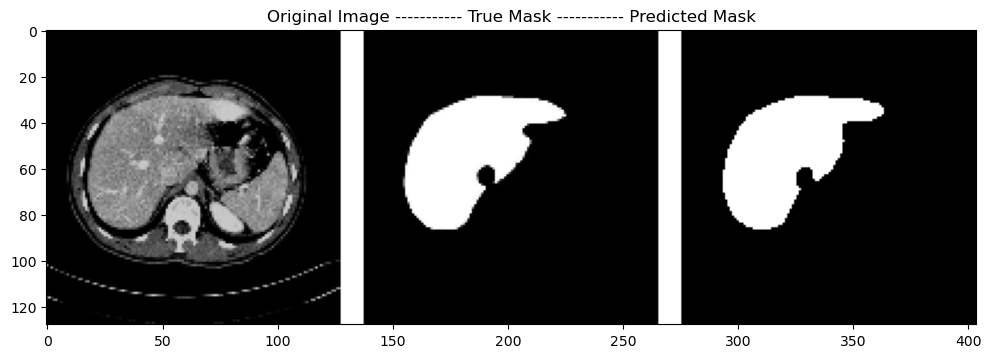

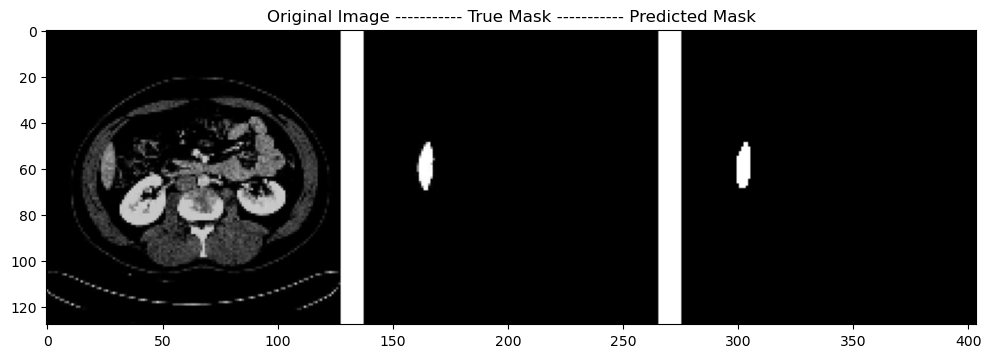

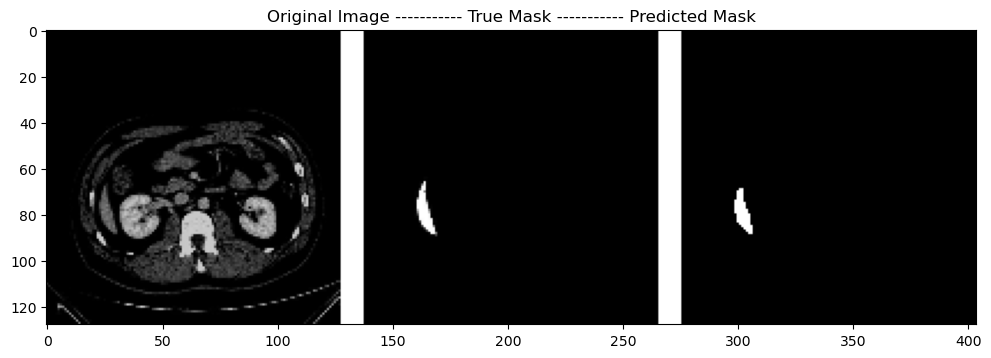

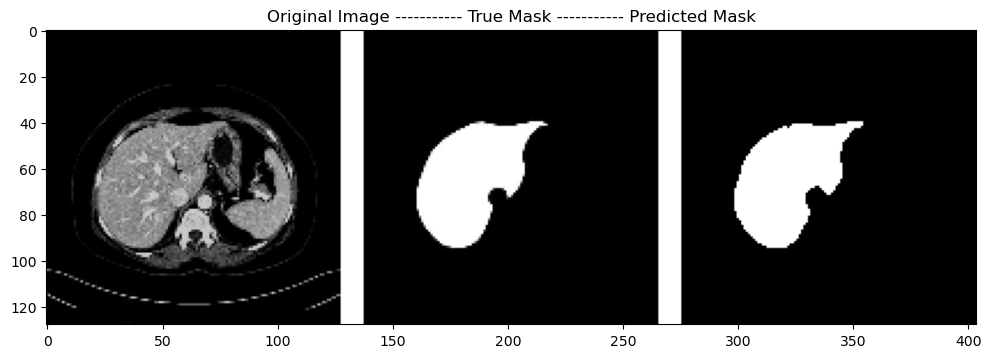

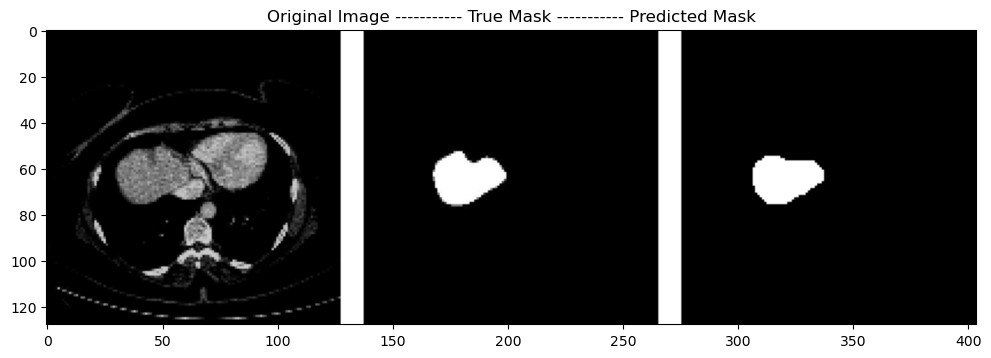

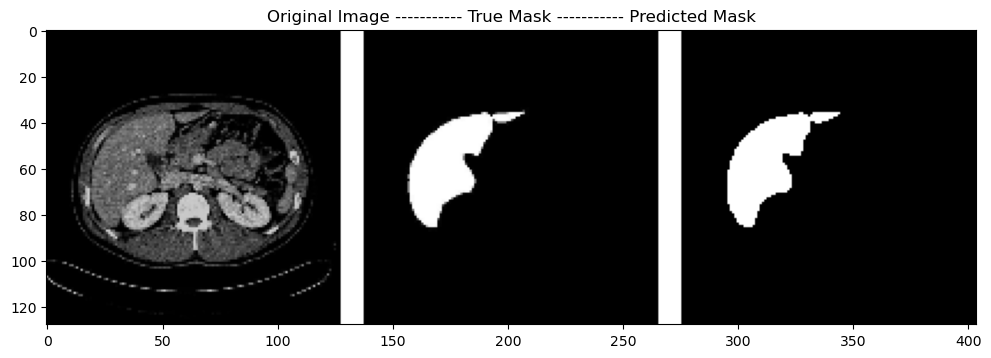

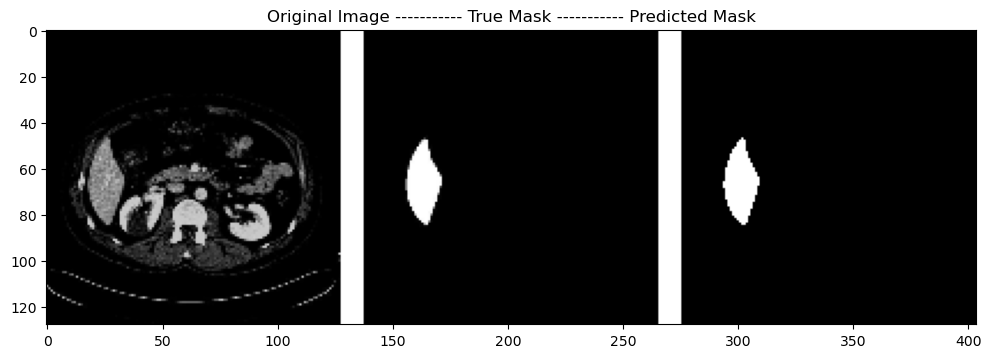

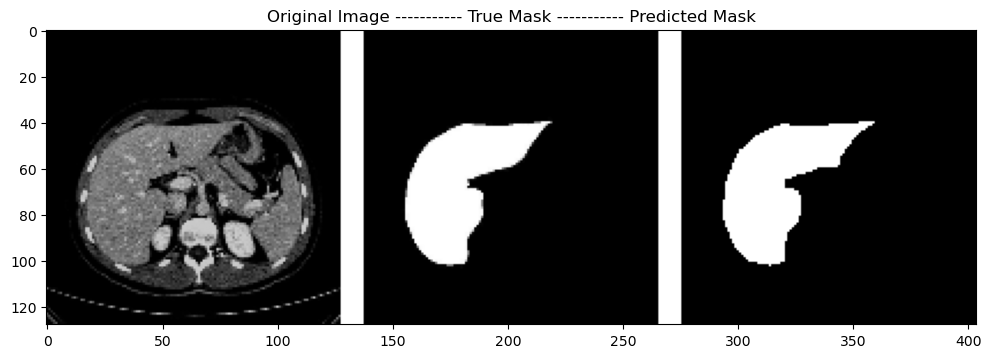

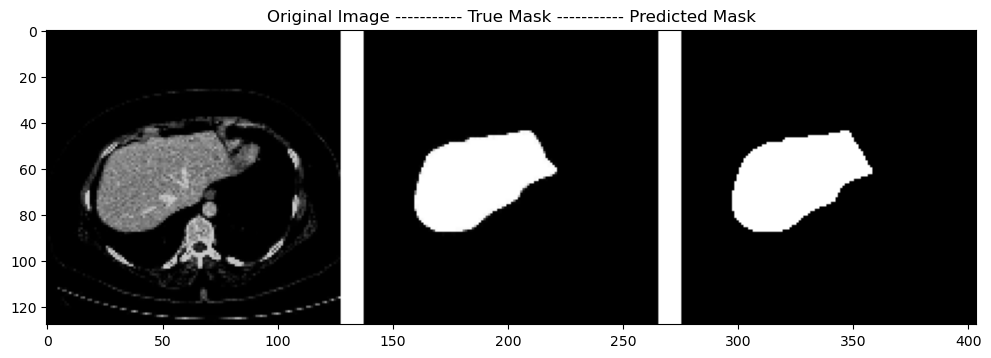

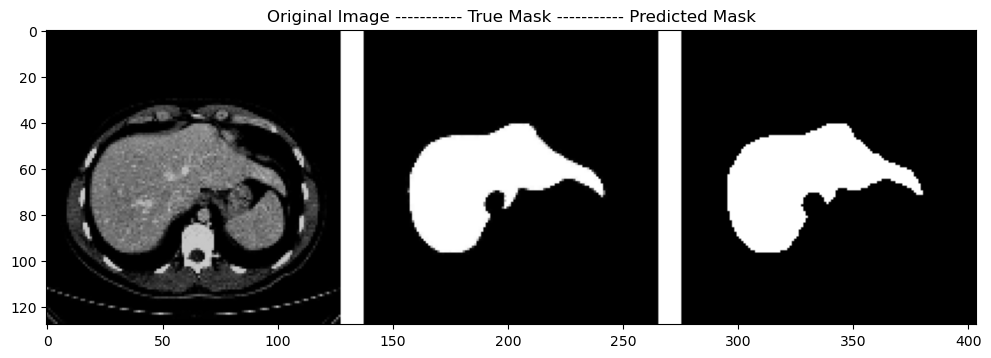

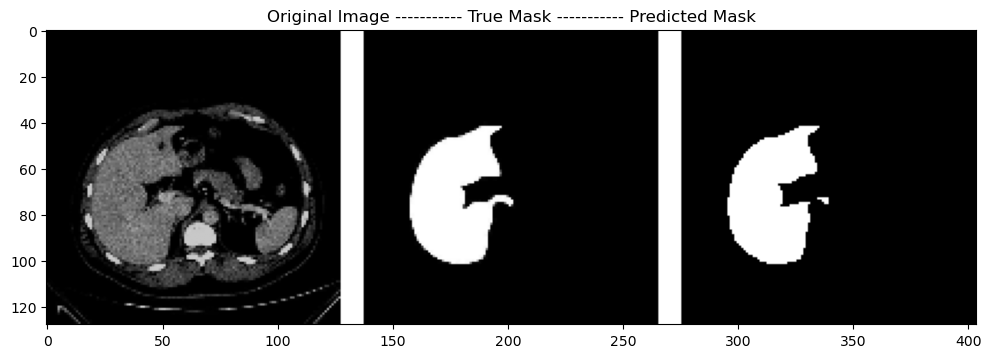

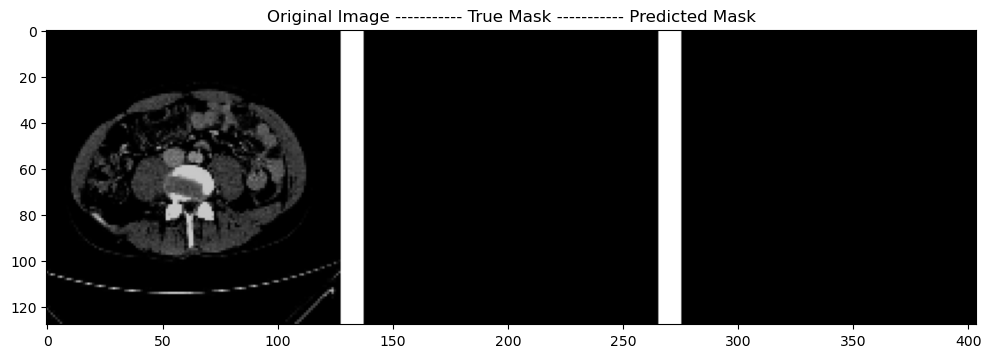

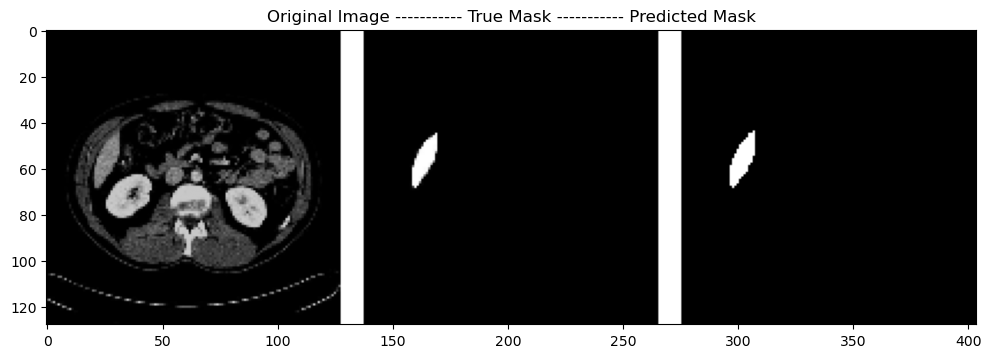

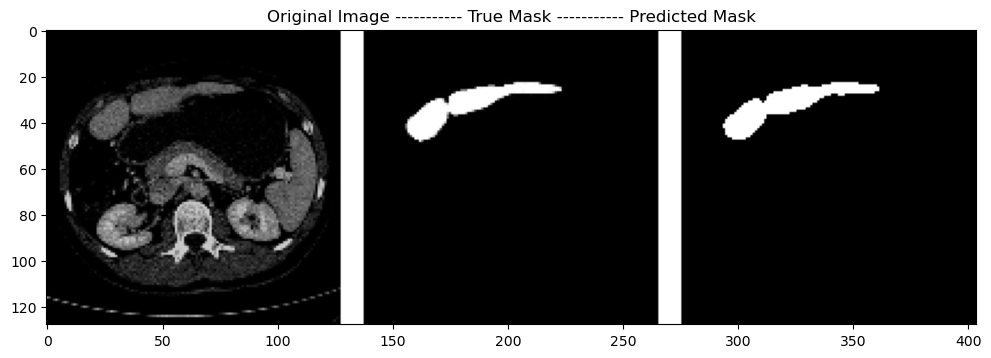

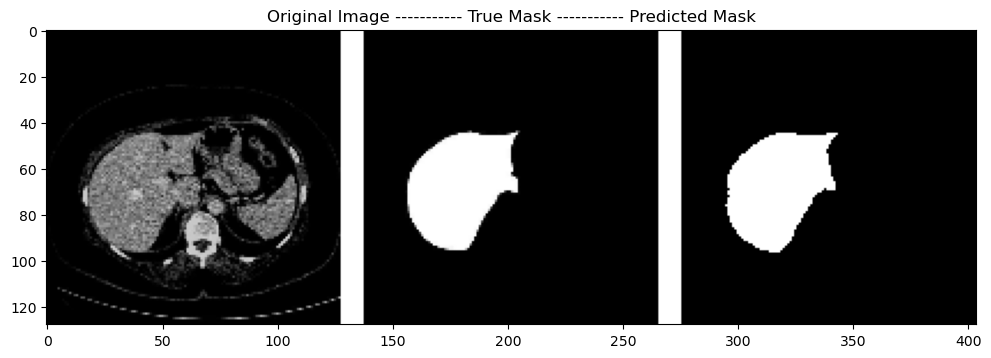

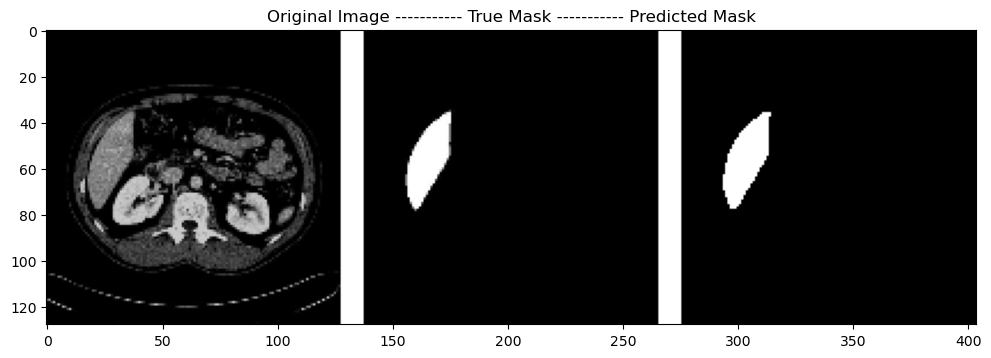

In [ ]:
model = load_model('/kaggle/input/chaosmodels/UNet++.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_image(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

test_x_folder_path = "/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/HU_CT_Images"
test_x_file_names = os.listdir(test_x_folder_path)
test_x = [os.path.join(test_x_folder_path, file_name) for file_name in test_x_file_names]
# test_x

test_y_folder_path = "/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/Liver_Masks"
test_y_file_names = os.listdir(test_y_folder_path)
test_y = [os.path.join(test_y_folder_path, file_name) for file_name in test_y_file_names]
# test_y
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

print("For UNet++:")
model.evaluate(test_dataset, steps=test_steps)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (128, 128))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (128, 128))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

for i, (x, y) in enumerate(zip(test_x[80:100], test_y[80:100])):
    print(x)
    print(y)
    x = read_image(x)
    y = read_mask(y)
    y_pred1 = model.predict(np.expand_dims(x, axis=0), verbose=0)[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3)) * 255
    all_images = [
        x,
        white_line,
        mask_parse(y),
        white_line,
        y_pred1
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    plt.title("Original Image ----------- True Mask ----------- Predicted Mask")
    imgplot = plt.imshow(image)

Model: "attunet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_backbone (Functional)    [(None, 128, 128, 6  14714688    ['input_1[0][0]']                
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                                 (None, 32, 32, 256                                   

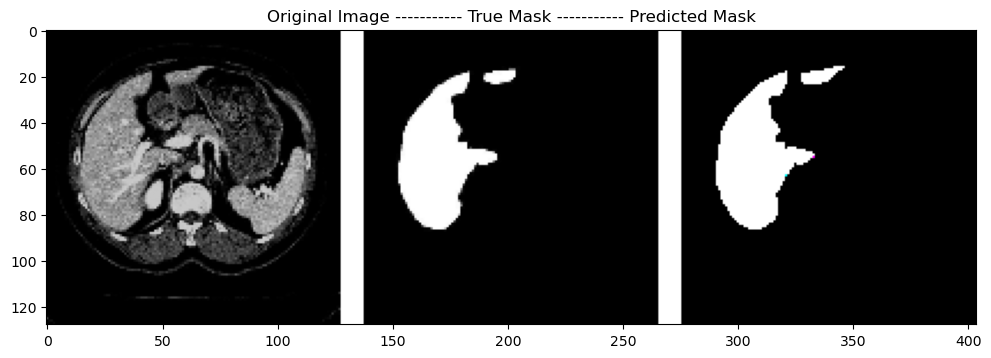

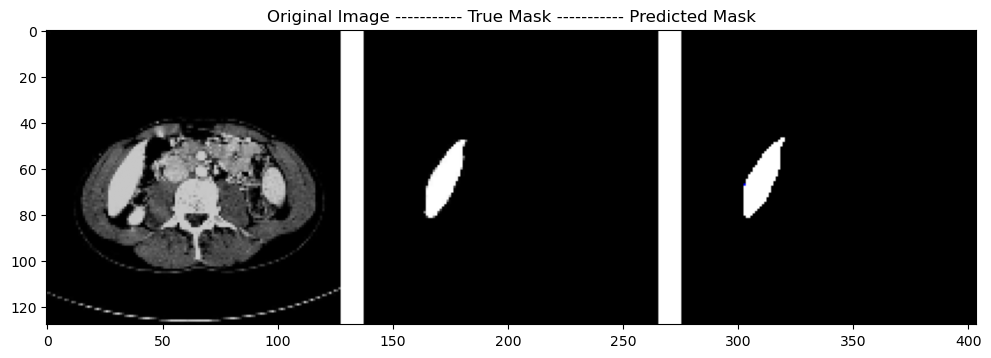

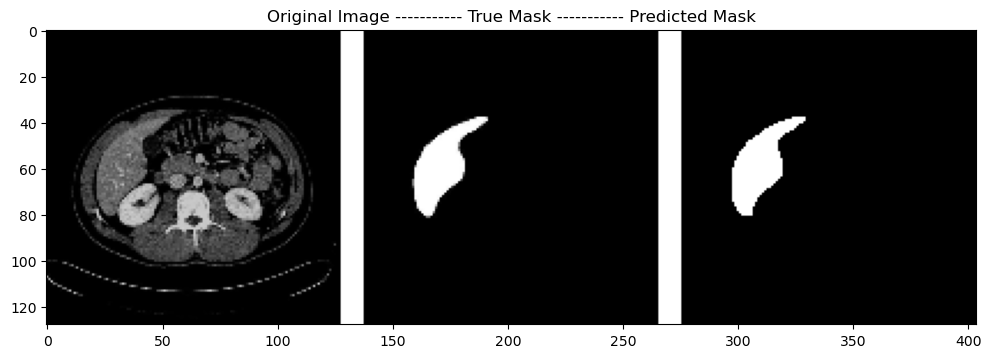

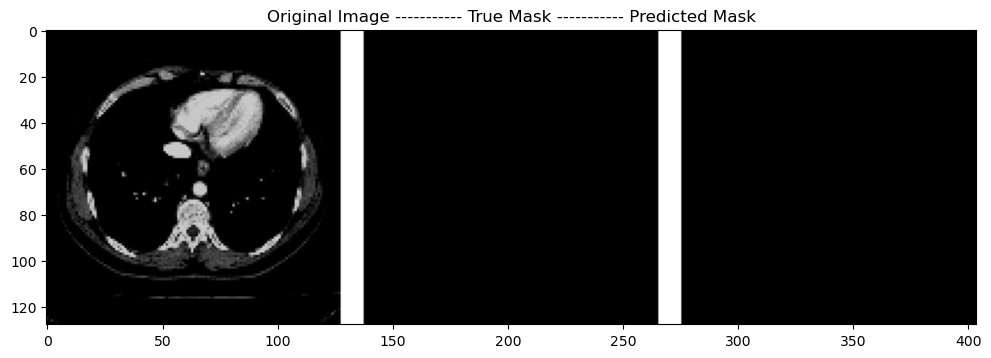

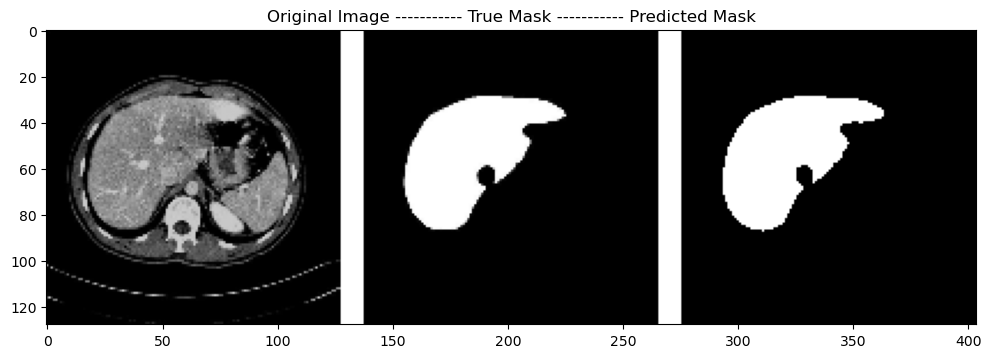

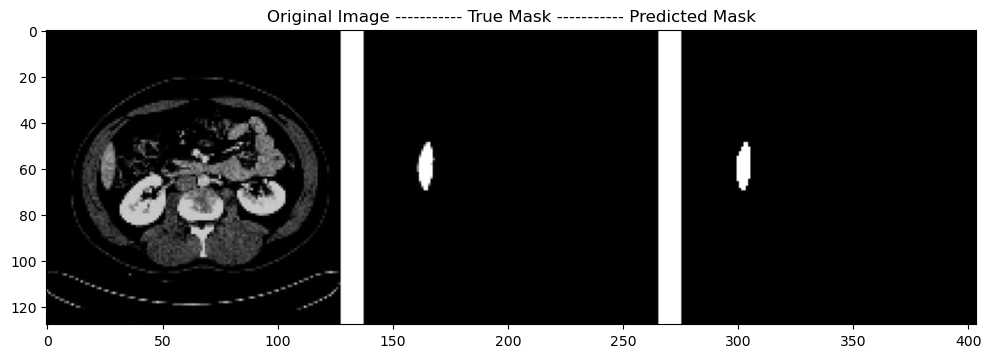

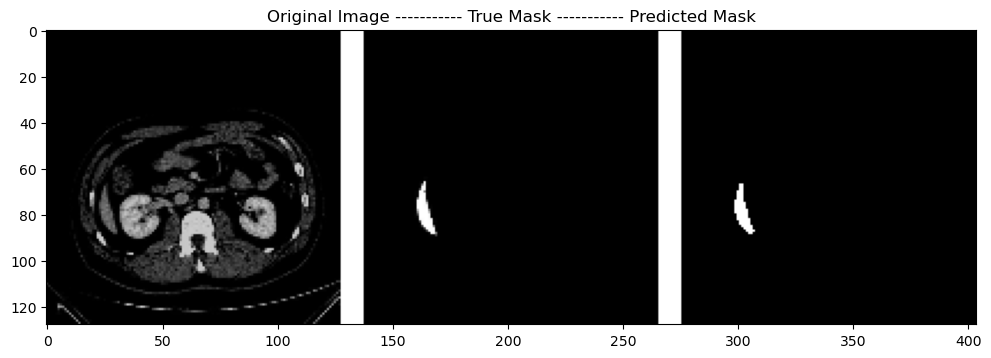

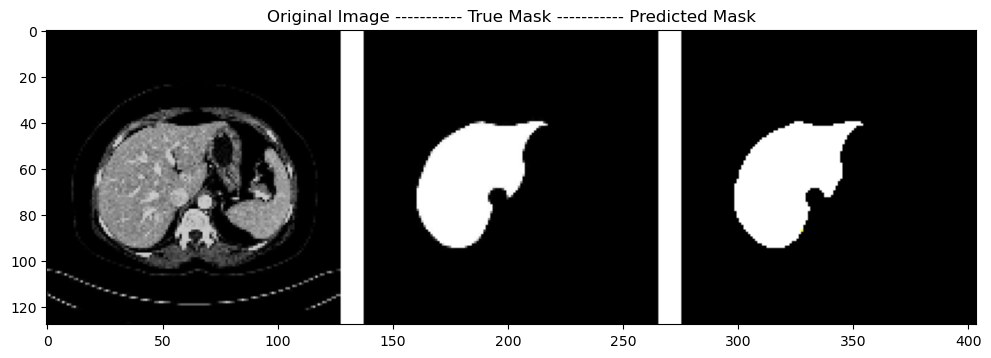

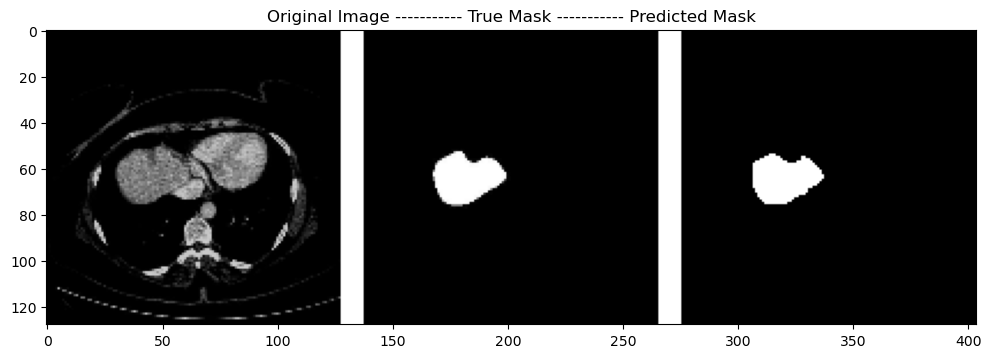

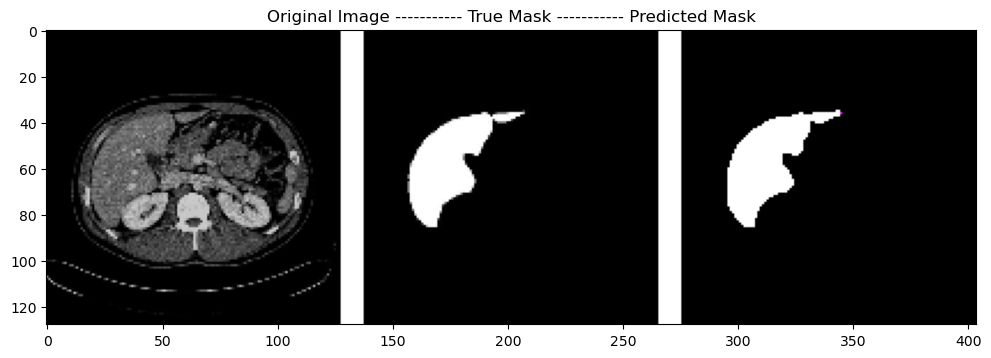

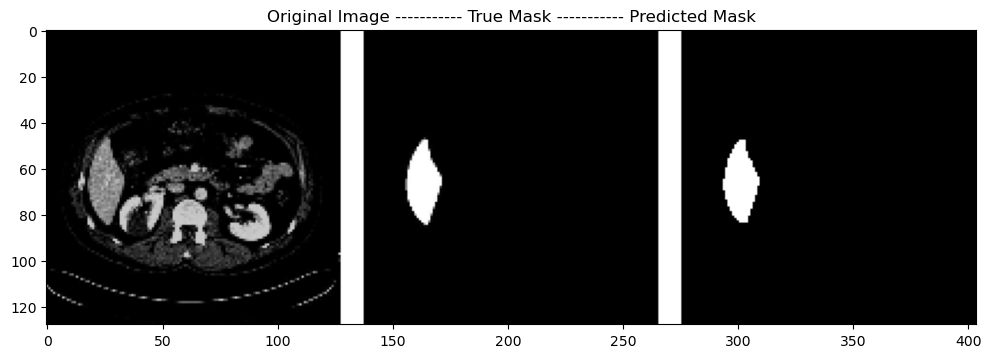

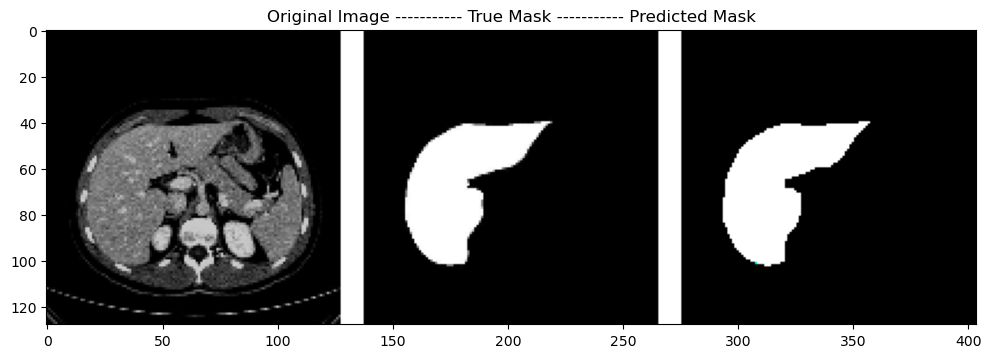

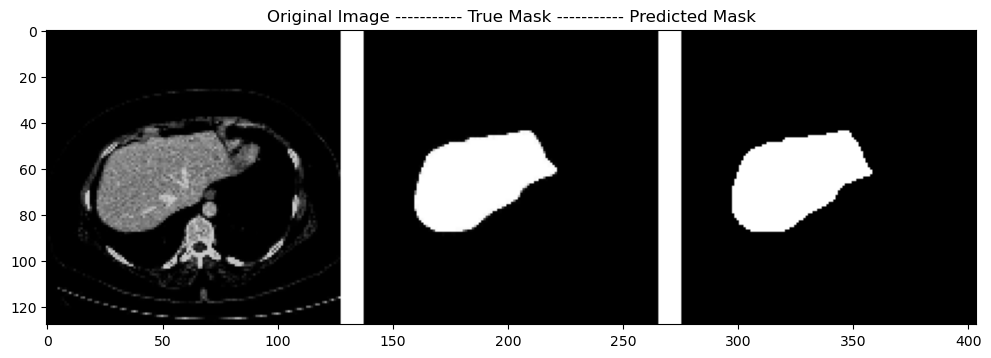

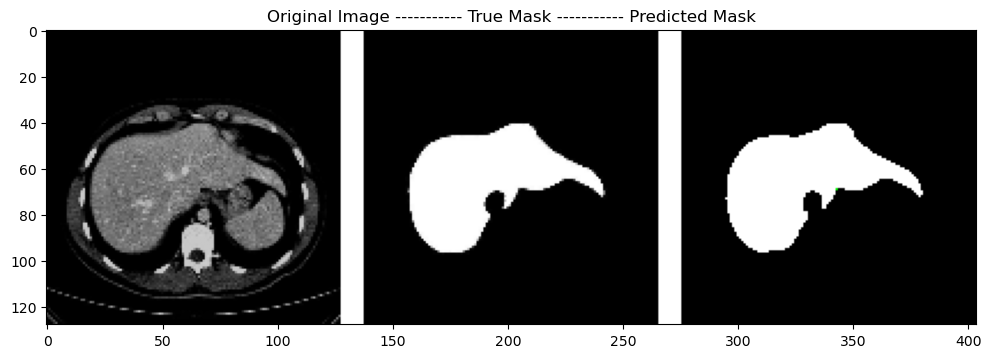

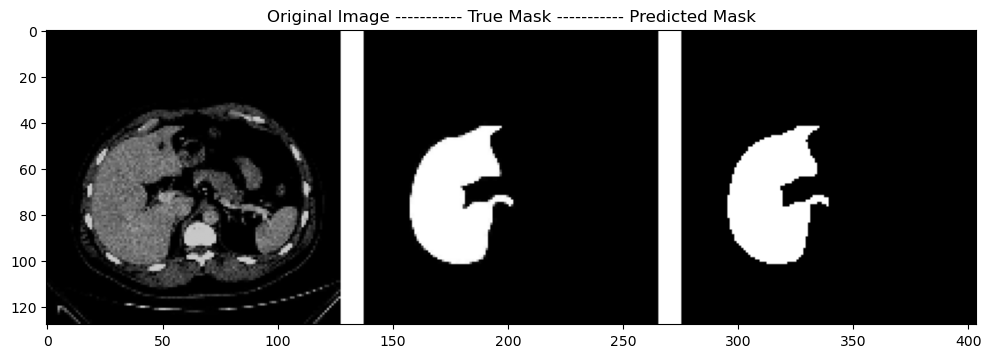

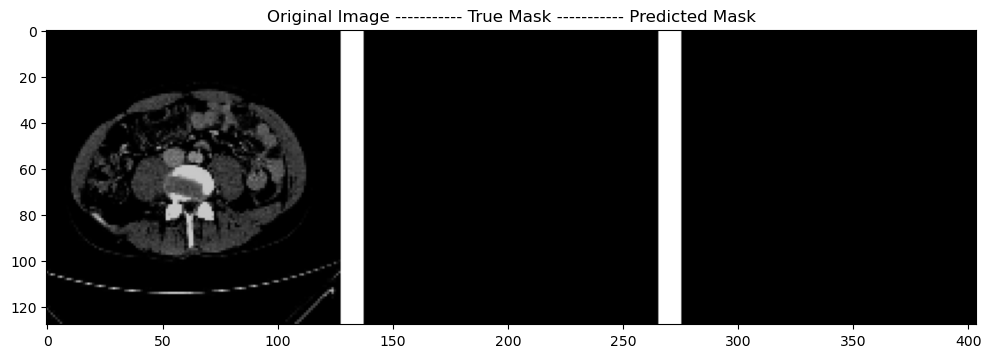

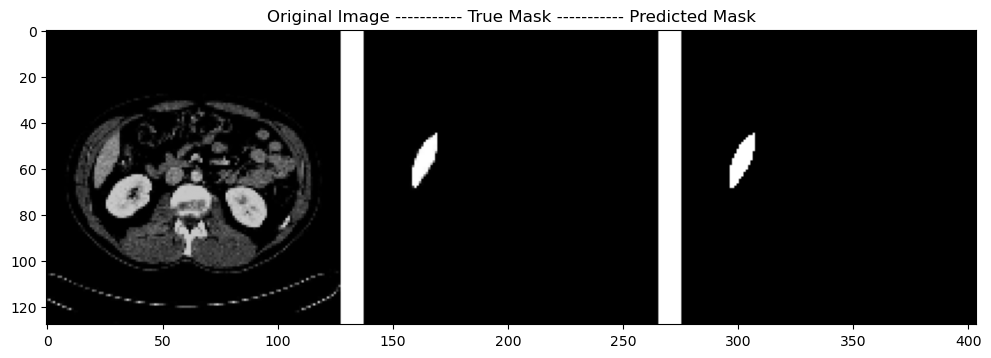

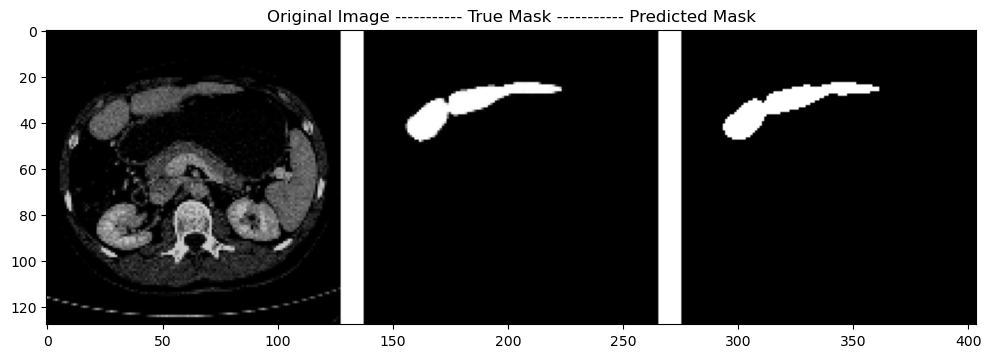

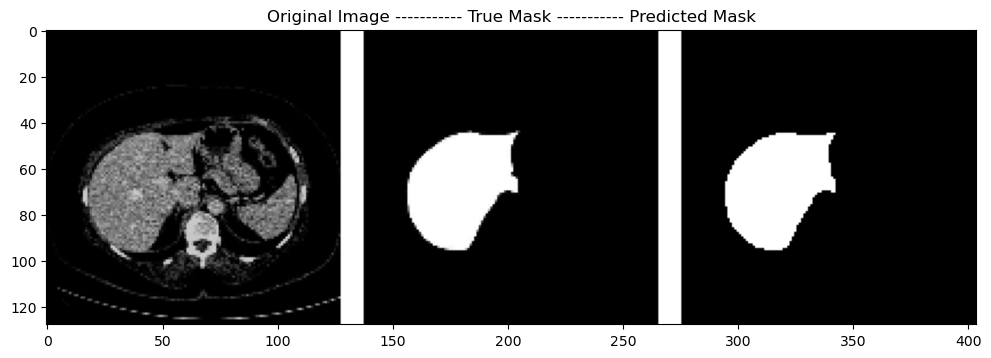

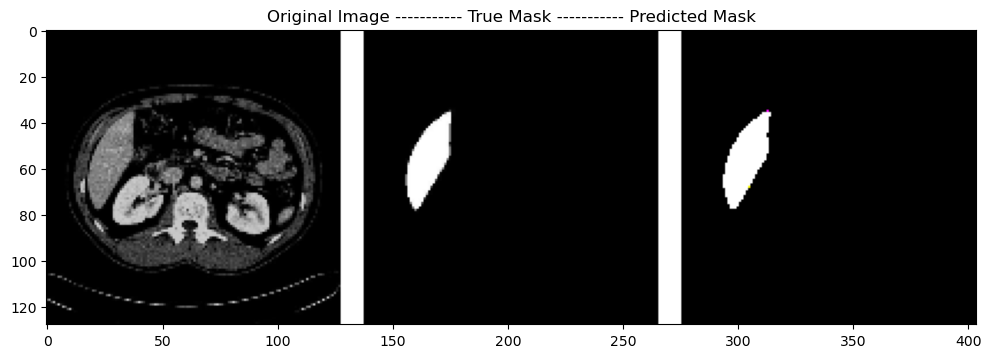

In [ ]:
model = load_model('/kaggle/input/chaosmodels/AttentionUNet2D.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_image(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

test_x_folder_path = "/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/HU_CT_Images"
test_x_file_names = os.listdir(test_x_folder_path)
test_x = [os.path.join(test_x_folder_path, file_name) for file_name in test_x_file_names]
# test_x

test_y_folder_path = "/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/Liver_Masks"
test_y_file_names = os.listdir(test_y_folder_path)
test_y = [os.path.join(test_y_folder_path, file_name) for file_name in test_y_file_names]
# test_y
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

print("For Attention UNet:")
model.evaluate(test_dataset, steps=test_steps)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (128, 128))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (128, 128))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

for i, (x, y) in enumerate(zip(test_x[80:100], test_y[80:100])):
    print(x)
    print(y)
    x = read_image(x)
    y = read_mask(y)
    y_pred1 = model.predict(np.expand_dims(x, axis=0), verbose=0)[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3)) * 255
    all_images = [
        x,
        white_line,
        mask_parse(y),
        white_line,
        y_pred1
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    plt.title("Original Image ----------- True Mask ----------- Predicted Mask")
    imgplot = plt.imshow(image)

In [1]:
model = load_model('/kaggle/input/chaosmodels/UNet3plus2D.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_image(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

test_x_folder_path = "/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/HU_CT_Images"
test_x_file_names = os.listdir(test_x_folder_path)
test_x = [os.path.join(test_x_folder_path, file_name) for file_name in test_x_file_names]
# test_x

test_y_folder_path = "/kaggle/input/chaostrvalte/CHAOS_tr_val_te/test/Liver_Masks"
test_y_file_names = os.listdir(test_y_folder_path)
test_y = [os.path.join(test_y_folder_path, file_name) for file_name in test_y_file_names]
# test_y
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

print("For Attention UNet:")
model.evaluate(test_dataset, steps=test_steps)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (128, 128))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (128, 128))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

for i, (x, y) in enumerate(zip(test_x[80:100], test_y[80:100])):
    print(x)
    print(y)
    x = read_image(x)
    y = read_mask(y)
    y_pred1 = model.predict(np.expand_dims(x, axis=0), verbose=0)[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3)) * 255
    all_images = [
        x,
        white_line,
        mask_parse(y),
        white_line,
        y_pred1
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    plt.title("Original Image ----------- True Mask ----------- Predicted Mask")
    imgplot = plt.imshow(image)

NameError: ignored

Model: "attunet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_backbone (Functional)    [(None, 128, 128, 6  14714688    ['input_1[0][0]']                
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                                 (None, 32, 32, 256                                   

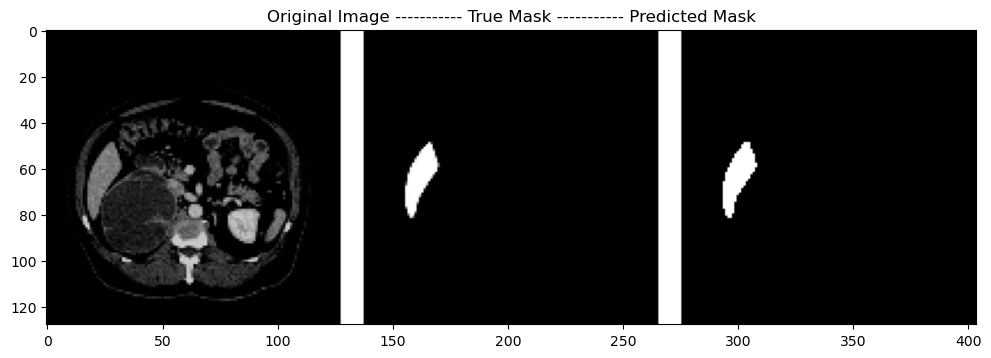

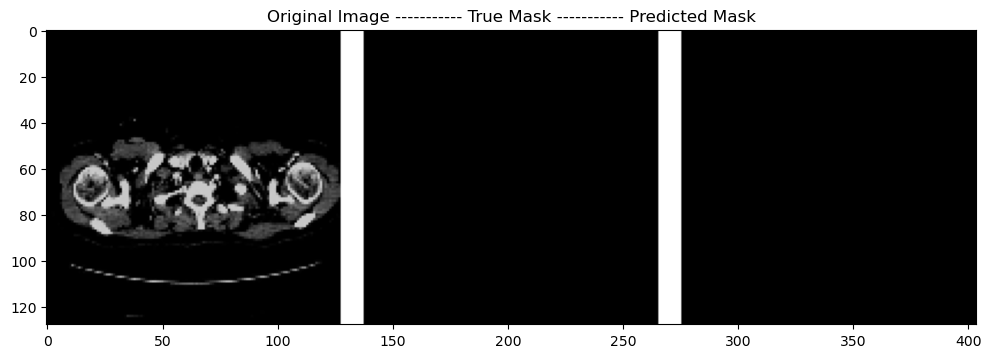

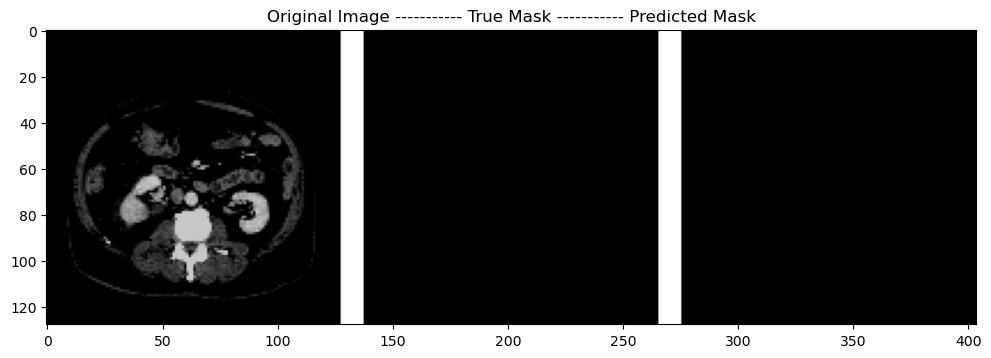

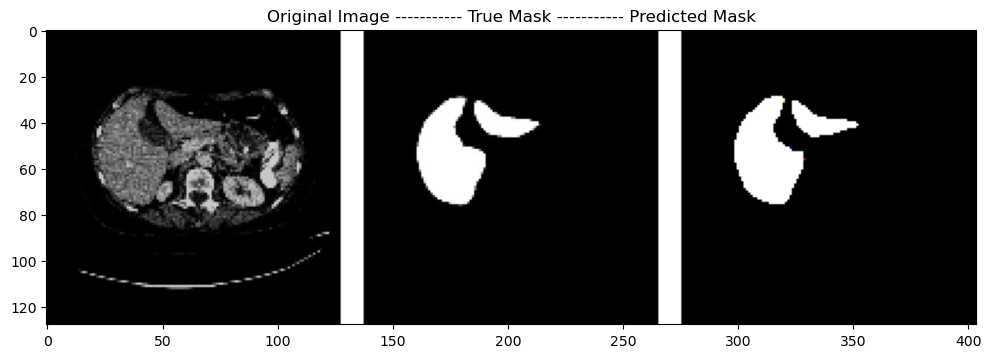

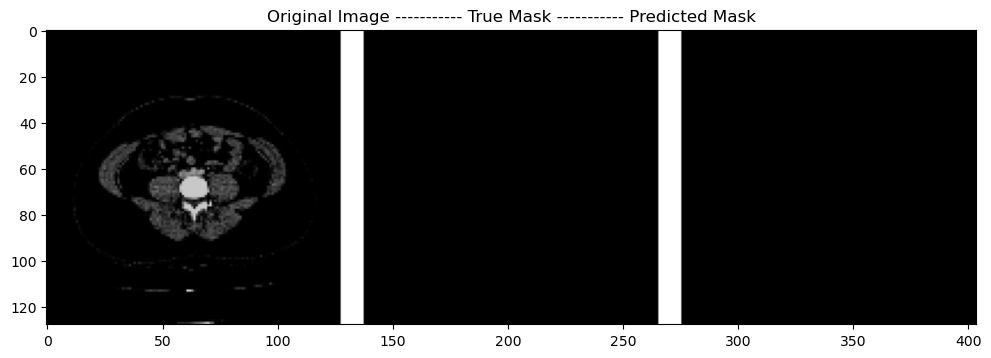

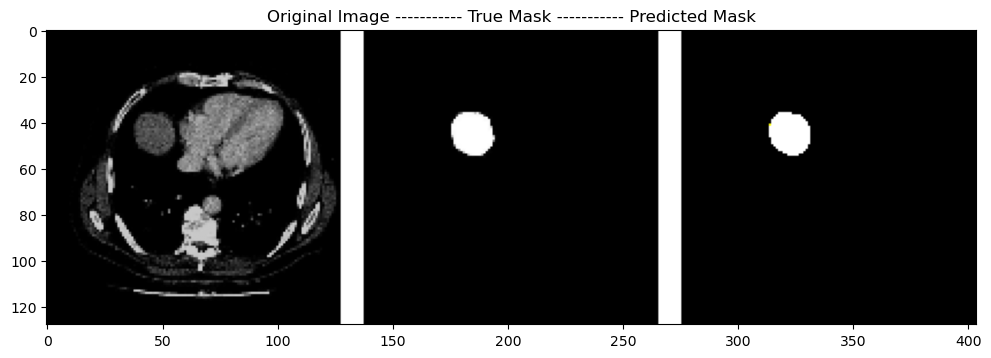

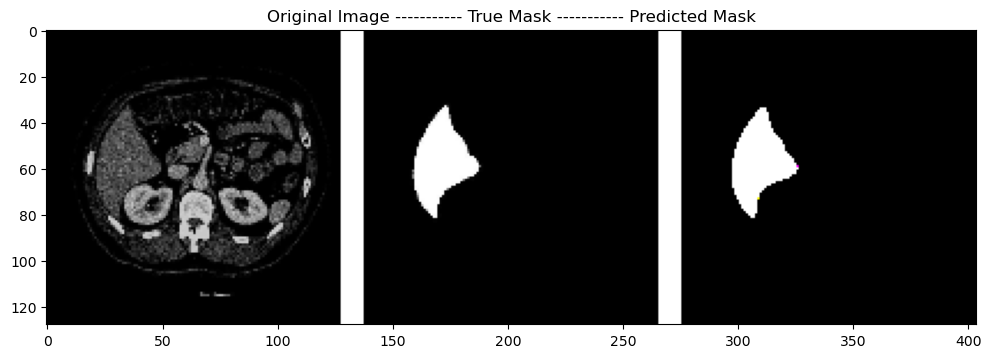

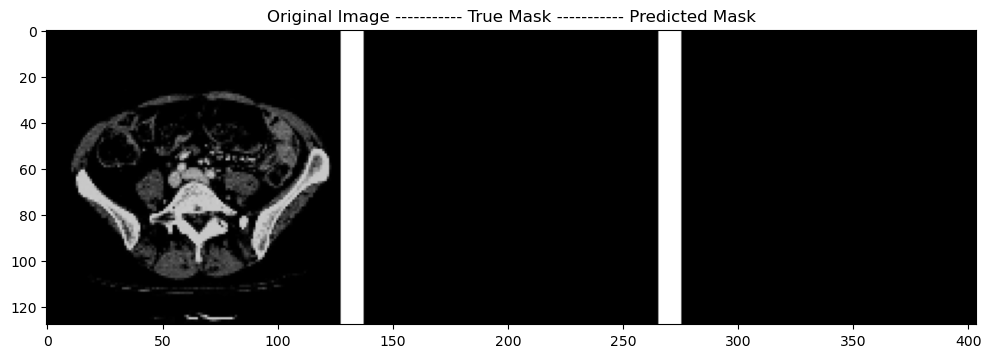

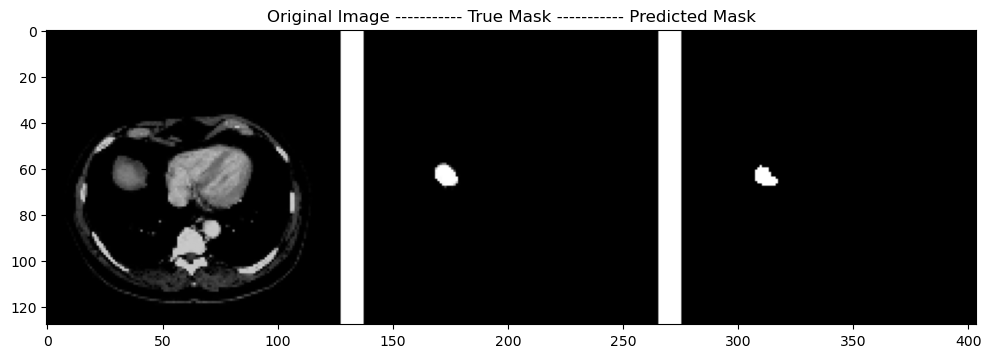

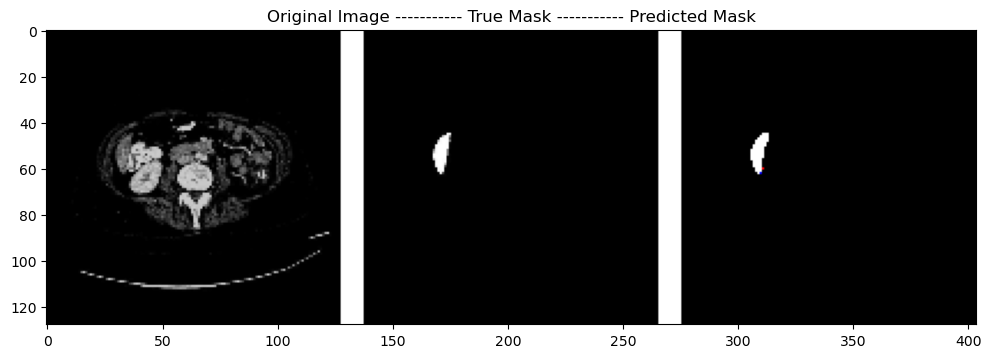

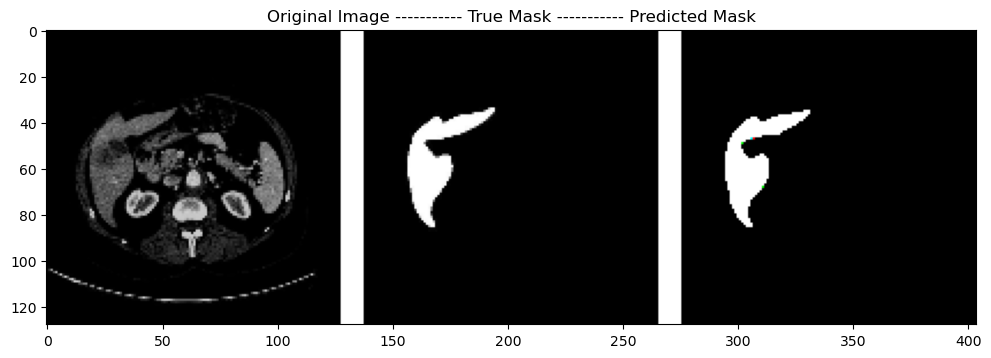

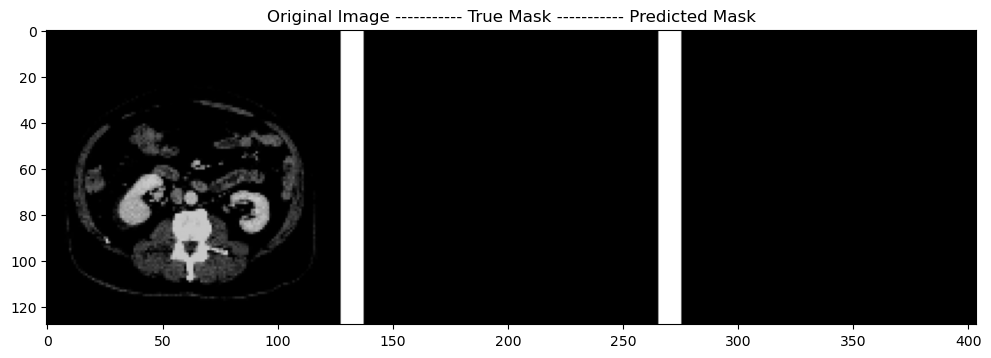

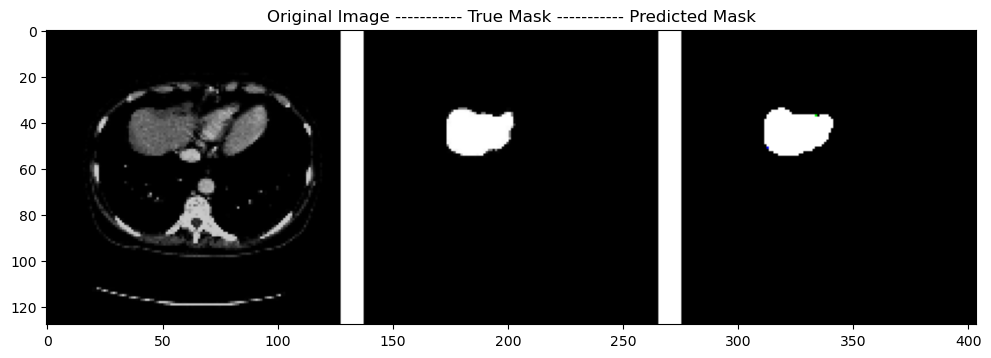

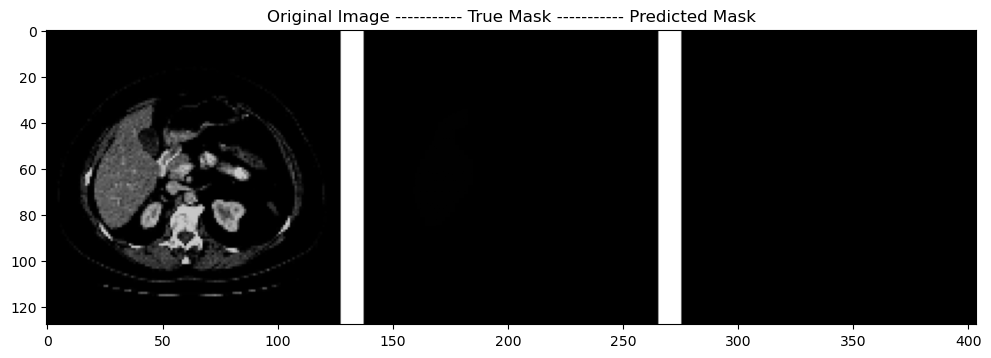

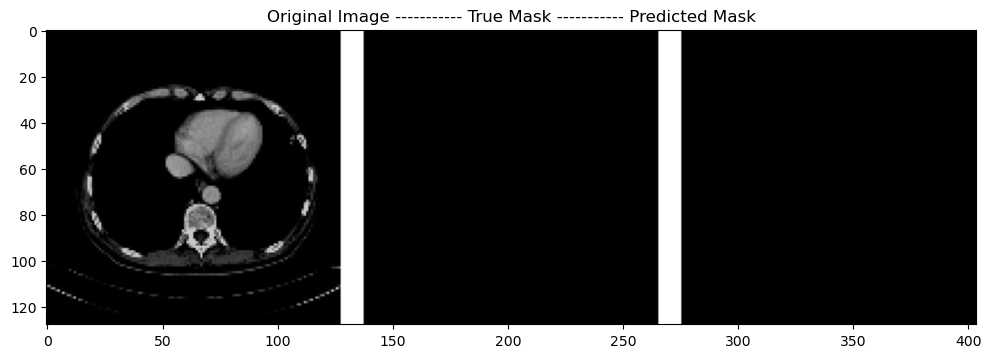

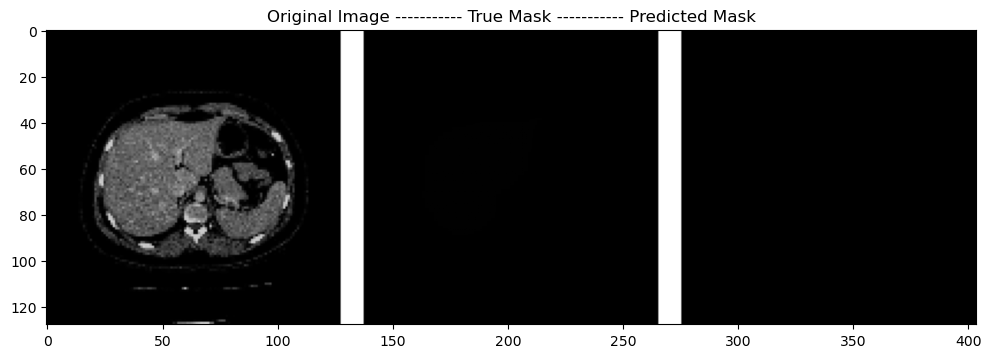

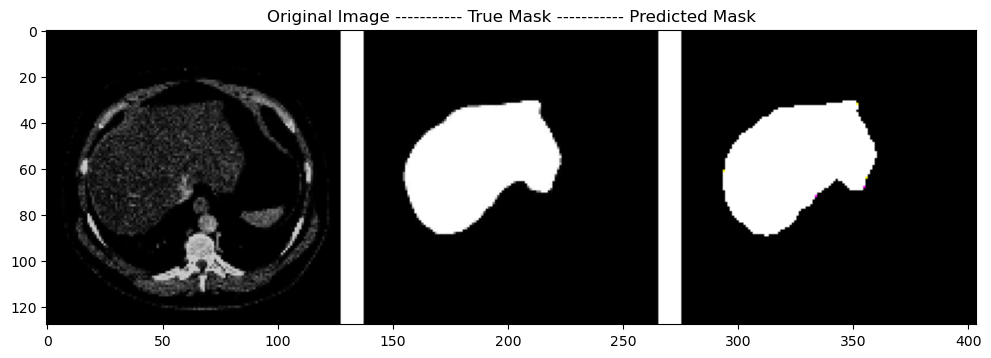

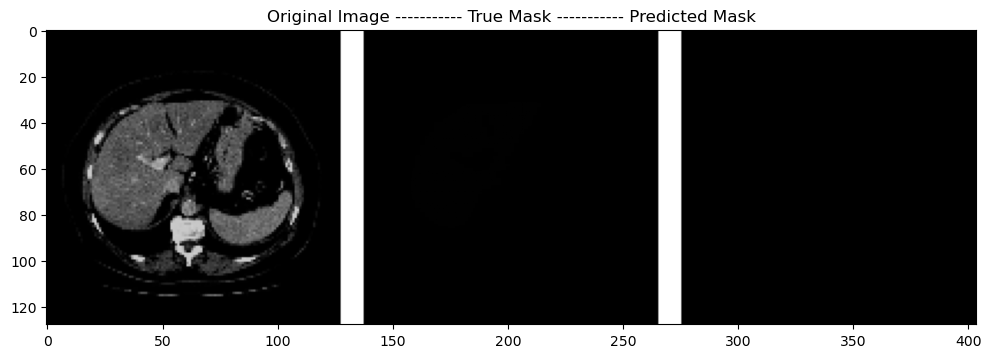

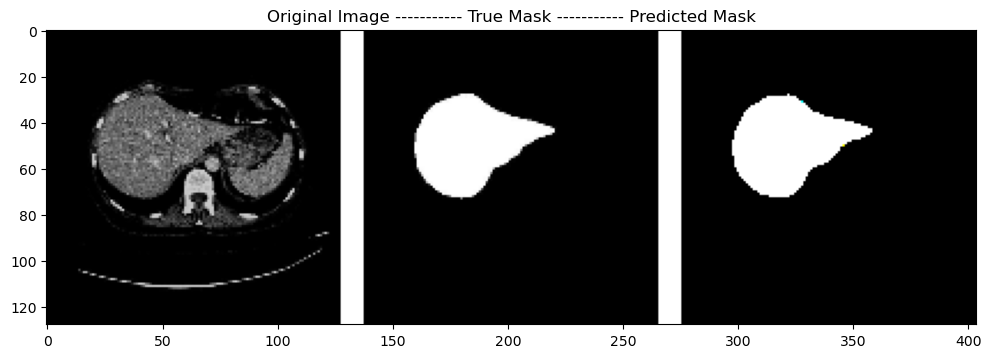

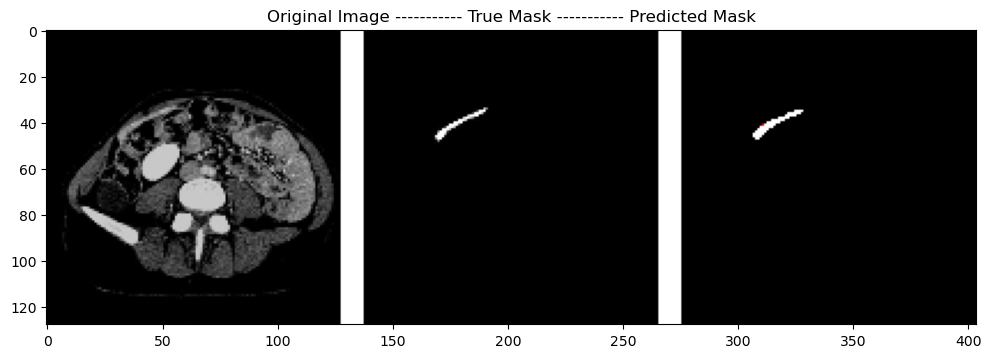

In [ ]:
model = load_model('/kaggle/input/3dircadbmodels/AttentionUNet.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_image(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

test_x_folder_path = "/kaggle/input/3dircadb-liver-tr-va-te/3DIRCADb_tr_va_te/test/CT_Images_HU_Clipped"
test_x_file_names = os.listdir(test_x_folder_path)
test_x = [os.path.join(test_x_folder_path, file_name) for file_name in test_x_file_names]
# test_x

test_y_folder_path = "/kaggle/input/3dircadb-liver-tr-va-te/3DIRCADb_tr_va_te/test/liver_masks"
test_y_file_names = os.listdir(test_y_folder_path)
test_y = [os.path.join(test_y_folder_path, file_name) for file_name in test_y_file_names]
# test_y
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

print("For Attention UNet:")
model.evaluate(test_dataset, steps=test_steps)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (128, 128))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (128, 128))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

for i, (x, y) in enumerate(zip(test_x[80:100], test_y[80:100])):
    print(x)
    print(y)
    x = read_image(x)
    y = read_mask(y)
    y_pred1 = model.predict(np.expand_dims(x, axis=0), verbose=0)[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3)) * 255
    all_images = [
        x,
        white_line,
        mask_parse(y),
        white_line,
        y_pred1
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    plt.title("Original Image ----------- True Mask ----------- Predicted Mask")
    imgplot = plt.imshow(image)

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_backbone (Functional)    [(None, 128, 128, 6  14714688    ['input_1[0][0]']                
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                                 (None, 32, 32, 256                                      

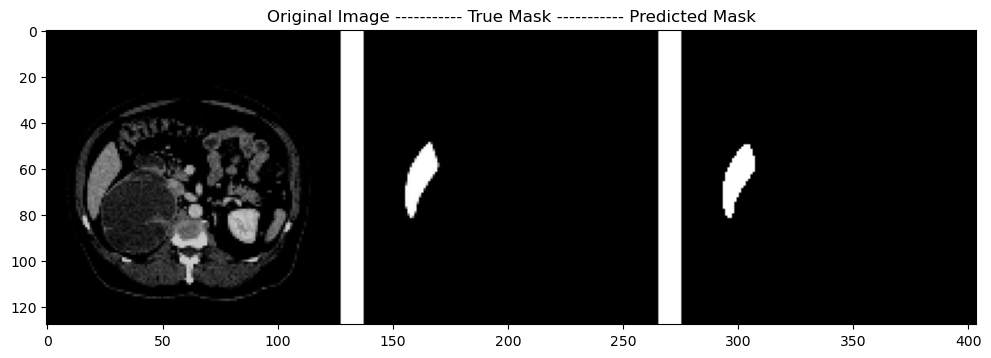

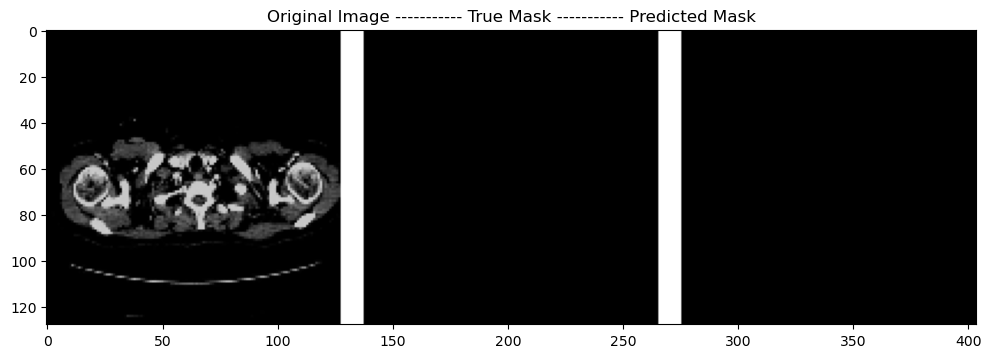

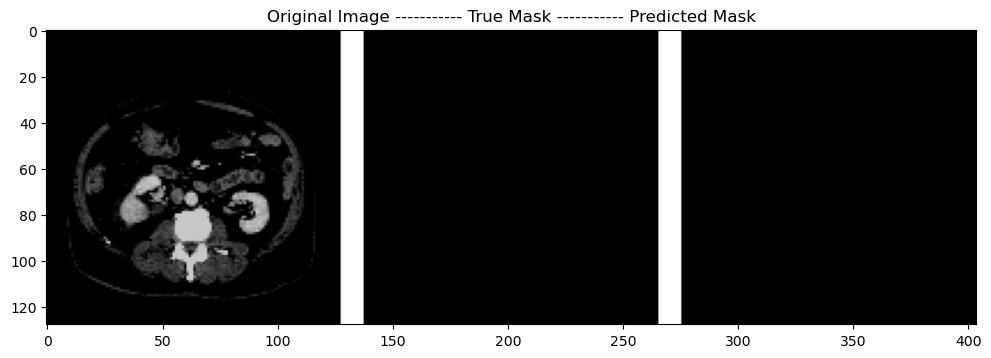

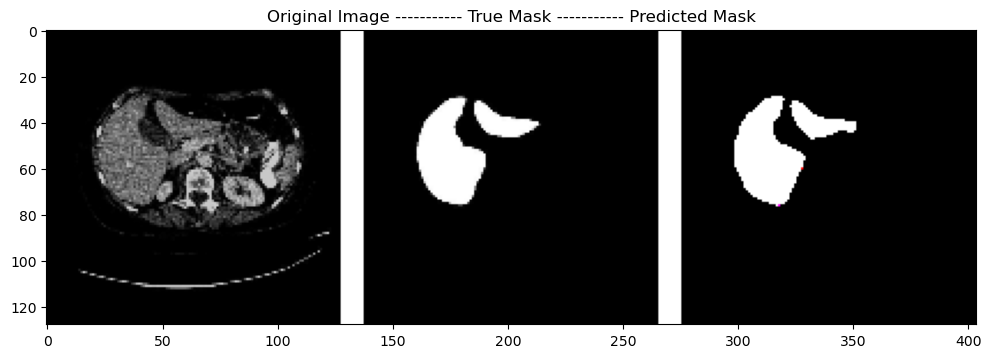

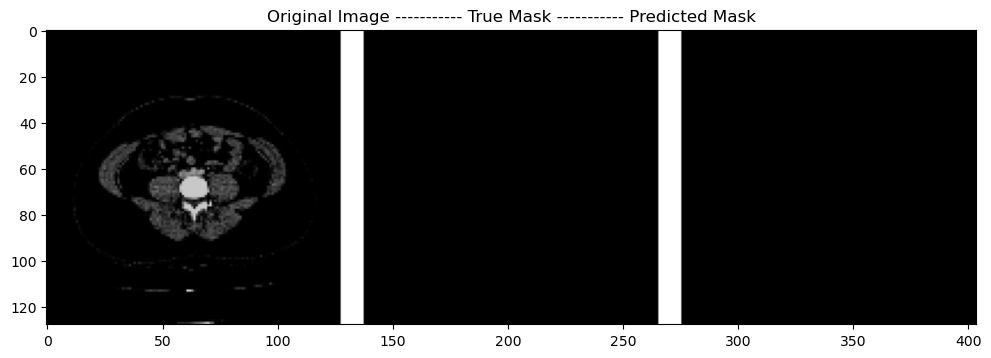

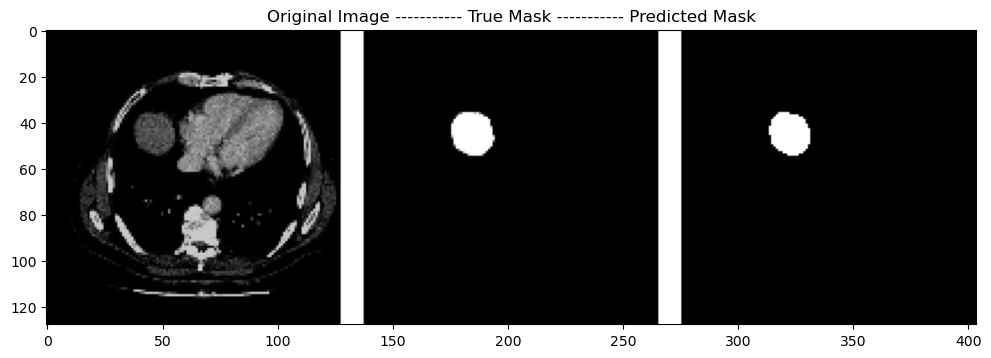

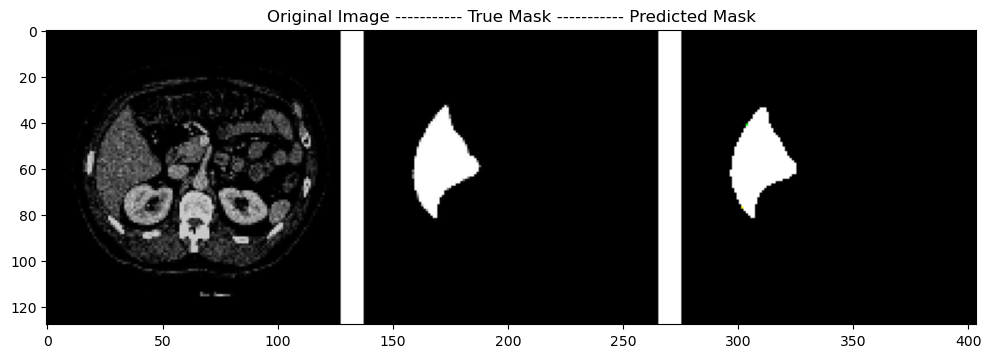

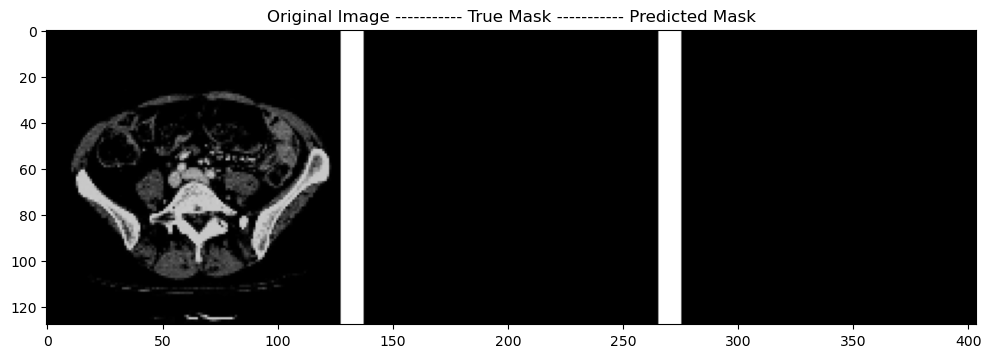

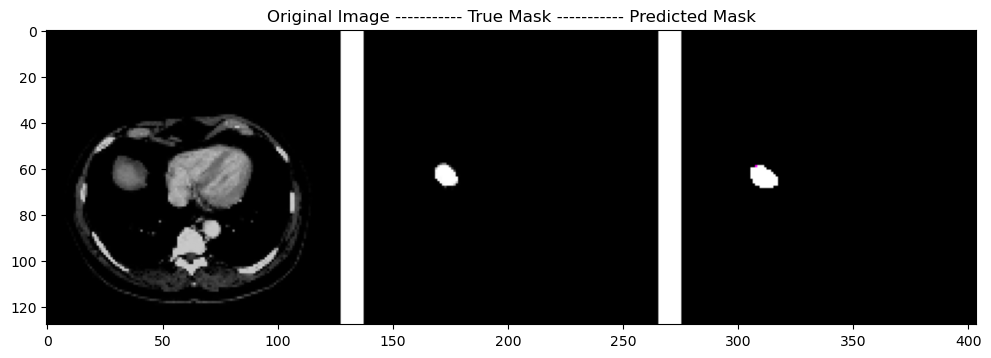

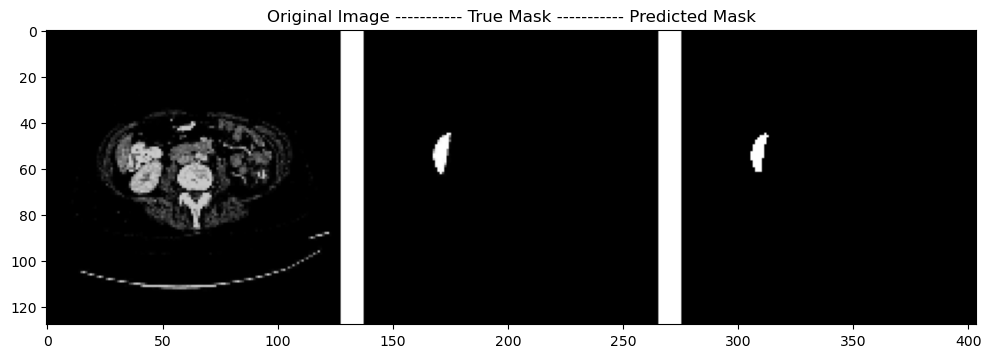

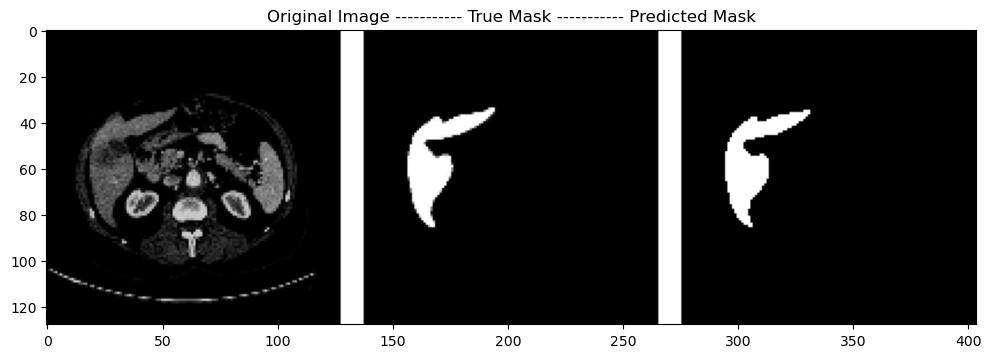

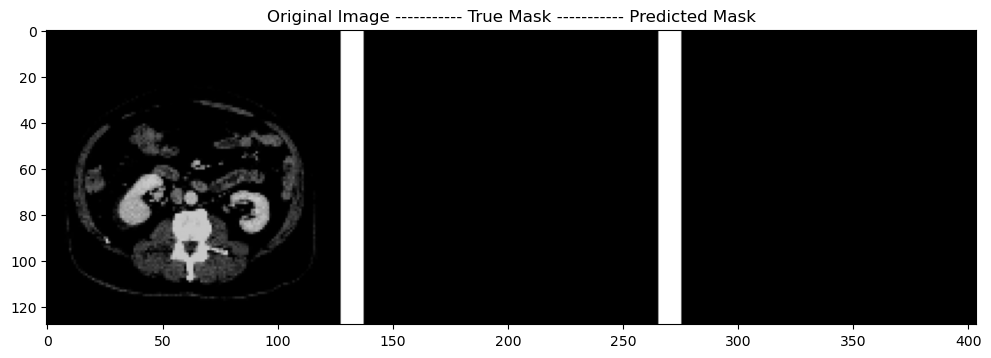

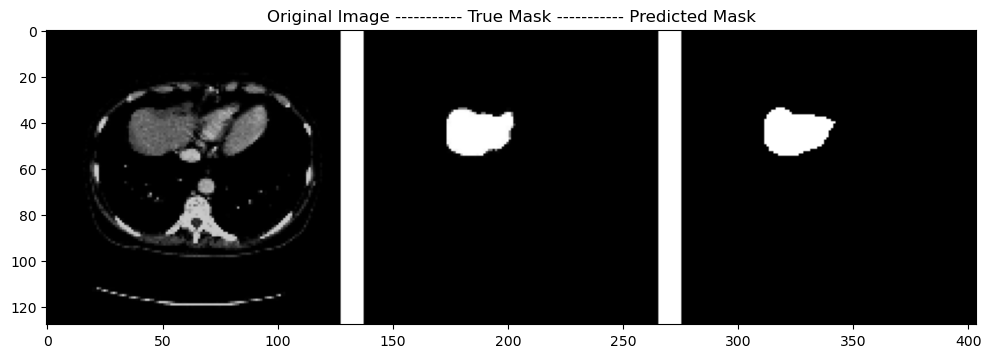

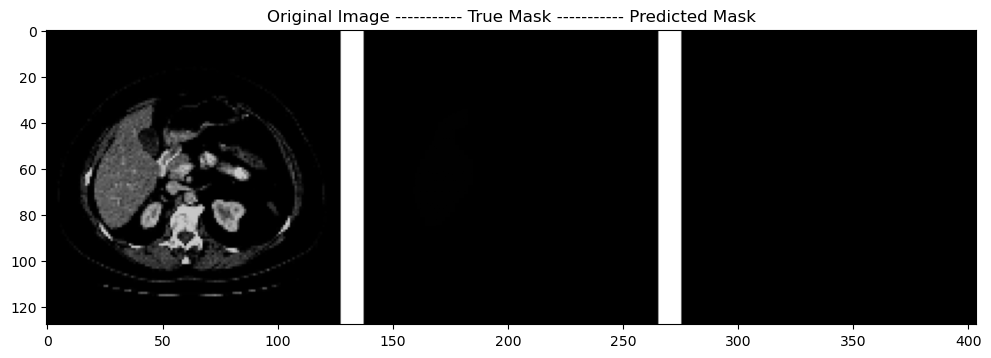

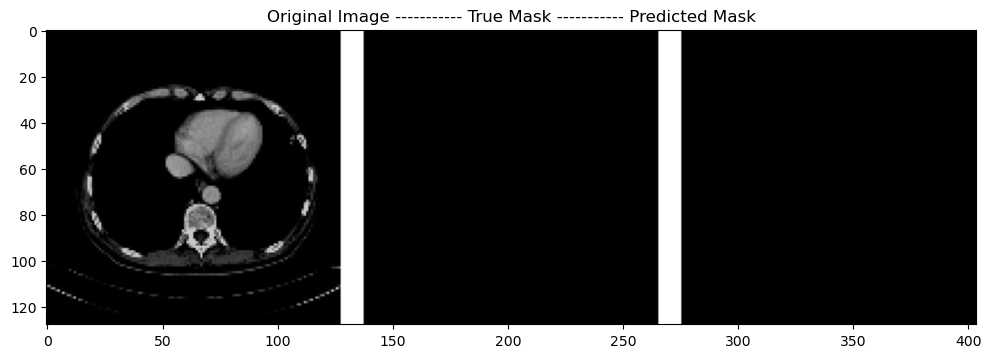

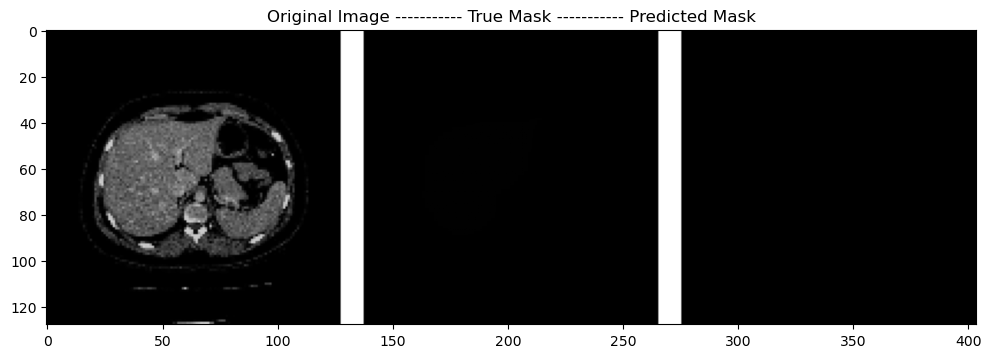

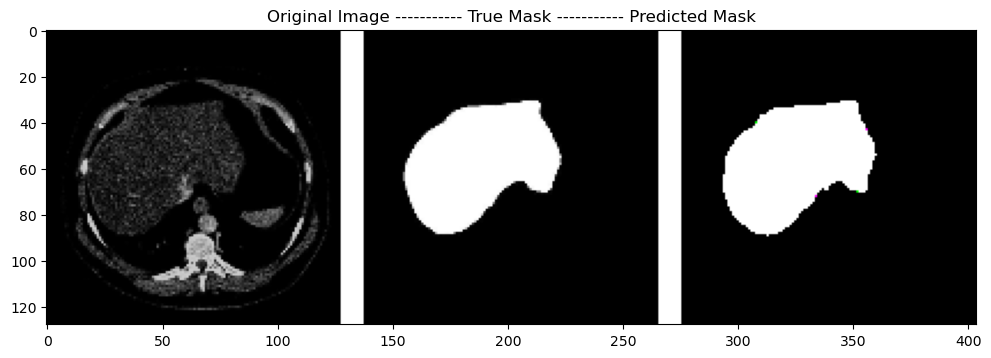

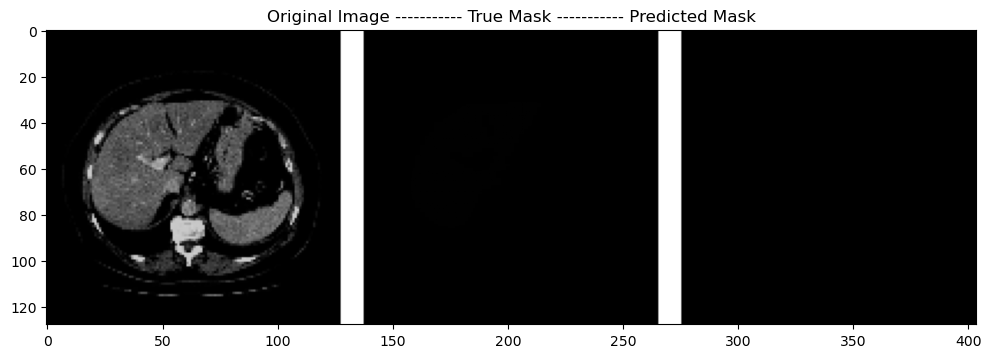

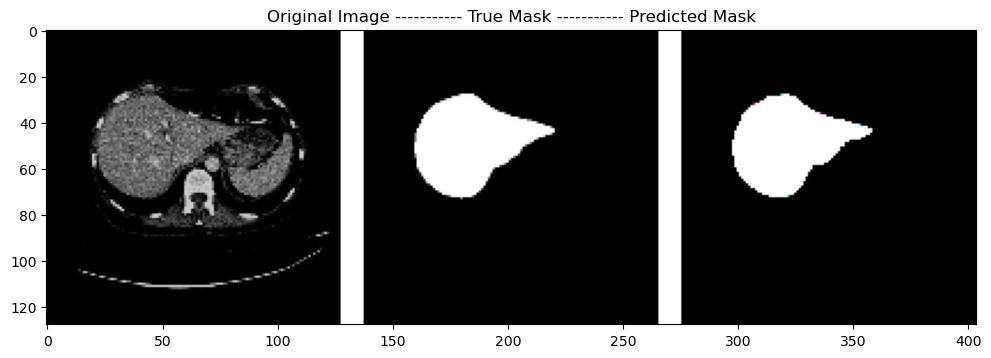

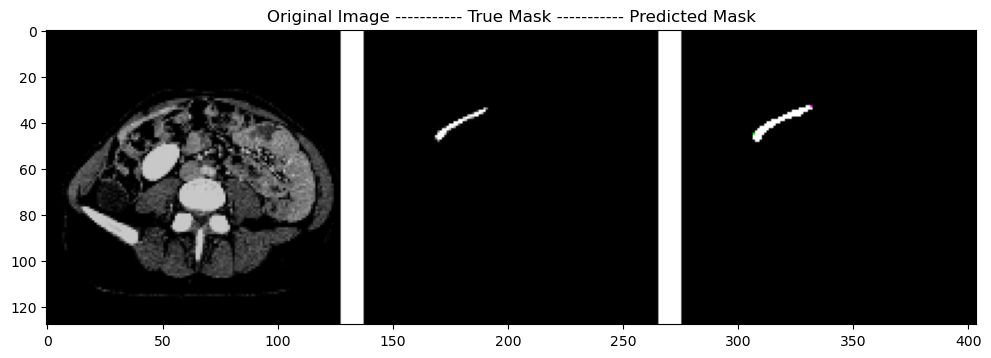

In [ ]:
model = load_model('/kaggle/input/3dircadbmodels/UNet2D.hdf5', compile= False)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_image(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

test_x_folder_path = "/kaggle/input/3dircadb-liver-tr-va-te/3DIRCADb_tr_va_te/test/CT_Images_HU_Clipped"
test_x_file_names = os.listdir(test_x_folder_path)
test_x = [os.path.join(test_x_folder_path, file_name) for file_name in test_x_file_names]
# test_x

test_y_folder_path = "/kaggle/input/3dircadb-liver-tr-va-te/3DIRCADb_tr_va_te/test/liver_masks"
test_y_file_names = os.listdir(test_y_folder_path)
test_y = [os.path.join(test_y_folder_path, file_name) for file_name in test_y_file_names]
# test_y
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

print("For Attention UNet:")
model.evaluate(test_dataset, steps=test_steps)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (128, 128))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (128, 128))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

for i, (x, y) in enumerate(zip(test_x[80:100], test_y[80:100])):
    print(x)
    print(y)
    x = read_image(x)
    y = read_mask(y)
    y_pred1 = model.predict(np.expand_dims(x, axis=0), verbose=0)[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3)) * 255
    all_images = [
        x,
        white_line,
        mask_parse(y),
        white_line,
        y_pred1
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    plt.title("Original Image ----------- True Mask ----------- Predicted Mask")
    imgplot = plt.imshow(image)